<a href="https://colab.research.google.com/github/aryan35790jp/chinese_evaluation/blob/main/Chinesescores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os, glob

DATA_DIR = "/content/data"
FIG_DIR  = "/content/figures"
TAB_DIR  = "/content/paper_tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

required = [
    "main_results.csv",
    "semantic_control_results.csv",
    "radical_dataset.csv",
    "mbert_similarity_matrix.npy",
    "chinese_bert_similarity_matrix.npy",
    "mbert_intra_pairs.npy",
    "mbert_inter_pairs.npy",
    "chinese_bert_intra_pairs.npy",
    "chinese_bert_inter_pairs.npy",
    "mbert_euclid_intra_pairs.npy",
    "mbert_euclid_inter_pairs.npy",
    "chinese_bert_euclid_intra_pairs.npy",
    "chinese_bert_euclid_inter_pairs.npy",
    "mbert_bootstrap.npy",
    "chinese_bert_bootstrap.npy",
    "mbert_euclid_bootstrap.npy",
    "chinese_bert_euclid_bootstrap.npy",
    "mbert_permutation_scores.npy",
    "chinese_bert_permutation_scores.npy",
    "mbert_euclid_permutation_scores.npy",
    "chinese_bert_euclid_permutation_scores.npy",
    "mbert_rad_cohesions.npy",
    "chinese_bert_rad_cohesions.npy",
    "mbert_rad_sizes.npy",
    "chinese_bert_rad_sizes.npy",
    "mbert_semantic_control_intra.npy",
    "mbert_semantic_control_cross.npy",
    "mbert_semantic_control_perm.npy",
    "chinese_bert_semantic_control_intra.npy",
    "chinese_bert_semantic_control_cross.npy",
    "chinese_bert_semantic_control_perm.npy",
]

missing = [f for f in required if not os.path.exists(os.path.join(DATA_DIR, f))]
if missing:
    print("MISSING FILES — upload these to /content/data before continuing:")
    for f in missing:
        print(f"  {f}")
else:
    print("ALL 31 required files found in /content/data")

print(f"\nTotal files in {DATA_DIR}:", len(os.listdir(DATA_DIR)))

ALL 31 required files found in /content/data

Total files in /content/data: 46


In [12]:
!pip install -q umap-learn

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

plt.rcParams.update({
    "figure.dpi":        320,
    "savefig.dpi":       320,
    "savefig.bbox":      "tight",
    "savefig.pad_inches": 0.03,
    "font.family":       "serif",
    "font.serif":        ["Times New Roman", "DejaVu Serif"],
    "font.size":         10,
    "axes.titlesize":    11,
    "axes.labelsize":    10,
    "xtick.labelsize":   8,
    "ytick.labelsize":   8,
    "legend.fontsize":   8,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.linewidth":    0.8,
})

# Colorblind-safe (IBM Design Library)
C_BLUE   = "#648FFF"   # mBERT
C_RED    = "#DC267F"    # Chinese-BERT
C_GRAY   = "#999999"
C_DARK   = "#323232"

print("Style ready.")

Style ready.


In [13]:
import os, numpy as np, pandas as pd

def npy(name):
    return np.load(os.path.join(DATA_DIR, name))

# === CSVs ===
# main_results.csv columns (wide format, 2 rows):
#   Model, Cos_Intra, Cos_Inter, Cos_Diff, Cos_p, Cos_p_holm, Cos_d,
#   Cos_CI_lo, Cos_CI_hi, Euc_Intra, Euc_Inter, Euc_Diff, Euc_p,
#   Euc_p_holm, Euc_d, Euc_CI_lo, Euc_CI_hi, Perm_p_cos, Perm_p_euc,
#   Size_rho, Size_p, Freq_rho, Freq_p
main_df = pd.read_csv(os.path.join(DATA_DIR, "main_results.csv"))

# semantic_control_results.csv columns:
#   Model, Field, Radical, Intra, Cross, p, d
sem_df = pd.read_csv(os.path.join(DATA_DIR, "semantic_control_results.csv"))

# radical_dataset.csv columns: char, radical
ds = pd.read_csv(os.path.join(DATA_DIR, "radical_dataset.csv"))

# === Similarity matrices (6306, 6306) — row order = radical_dataset.csv ===
m_sim = npy("mbert_similarity_matrix.npy")
c_sim = npy("chinese_bert_similarity_matrix.npy")

# === Cosine intra/inter (1-D float64) ===
m_intra = npy("mbert_intra_pairs.npy")
m_inter = npy("mbert_inter_pairs.npy")
c_intra = npy("chinese_bert_intra_pairs.npy")
c_inter = npy("chinese_bert_inter_pairs.npy")

# === Euclidean intra/inter (1-D float64) ===
m_e_intra = npy("mbert_euclid_intra_pairs.npy")
m_e_inter = npy("mbert_euclid_inter_pairs.npy")
c_e_intra = npy("chinese_bert_euclid_intra_pairs.npy")
c_e_inter = npy("chinese_bert_euclid_inter_pairs.npy")

# === Bootstrap Δ distributions (1000,) ===
m_boot   = npy("mbert_bootstrap.npy")
c_boot   = npy("chinese_bert_bootstrap.npy")
m_e_boot = npy("mbert_euclid_bootstrap.npy")
c_e_boot = npy("chinese_bert_euclid_bootstrap.npy")

# === Permutation null distributions ===
# Cosine (1000,), Euclidean (1000,)
m_perm   = npy("mbert_permutation_scores.npy")
c_perm   = npy("chinese_bert_permutation_scores.npy")
m_e_perm = npy("mbert_euclid_permutation_scores.npy")
c_e_perm = npy("chinese_bert_euclid_permutation_scores.npy")

# === Per-radical summary arrays (68,) — NOT dicts ===
m_coh  = npy("mbert_rad_cohesions.npy")          # (68,) float64
c_coh  = npy("chinese_bert_rad_cohesions.npy")
m_rsz  = npy("mbert_rad_sizes.npy")              # (68,) int64
c_rsz  = npy("chinese_bert_rad_sizes.npy")

# === Semantic control arrays ===
m_sem_intra = npy("mbert_semantic_control_intra.npy")         # (40,)
m_sem_cross = npy("mbert_semantic_control_cross.npy")         # (100,)
m_sem_perm  = npy("mbert_semantic_control_perm.npy")          # (5000,)
c_sem_intra = npy("chinese_bert_semantic_control_intra.npy")
c_sem_cross = npy("chinese_bert_semantic_control_cross.npy")
c_sem_perm  = npy("chinese_bert_semantic_control_perm.npy")

# === Sanity checks ===
assert m_sim.shape == (len(ds), len(ds)), f"sim_matrix shape {m_sim.shape} != dataset rows {len(ds)}"
assert len(m_coh) == 68, f"Expected 68 radicals, got {len(m_coh)}"
assert len(m_boot) == 1000
assert len(m_sem_perm) == 5000

print(f"Dataset:       {len(ds)} characters")
print(f"Sim matrices:  {m_sim.shape}")
print(f"Radicals:      {len(m_coh)}")
print(f"main_results:  {list(main_df.columns)}")
print(f"sem_control:   {list(sem_df.columns)}")
print("ALL CHECKS PASSED")

Dataset:       6306 characters
Sim matrices:  (6306, 6306)
Radicals:      68
main_results:  ['Model', 'Cos_Intra', 'Cos_Inter', 'Cos_Diff', 'Cos_p', 'Cos_p_holm', 'Cos_d', 'Cos_CI_lo', 'Cos_CI_hi', 'Euc_Intra', 'Euc_Inter', 'Euc_Diff', 'Euc_p', 'Euc_p_holm', 'Euc_d', 'Euc_CI_lo', 'Euc_CI_hi', 'Perm_p_cos', 'Perm_p_euc', 'Size_rho', 'Size_p', 'Freq_rho', 'Freq_p']
sem_control:   ['Model', 'Field', 'Radical', 'Intra', 'Cross', 'p', 'd']
ALL CHECKS PASSED


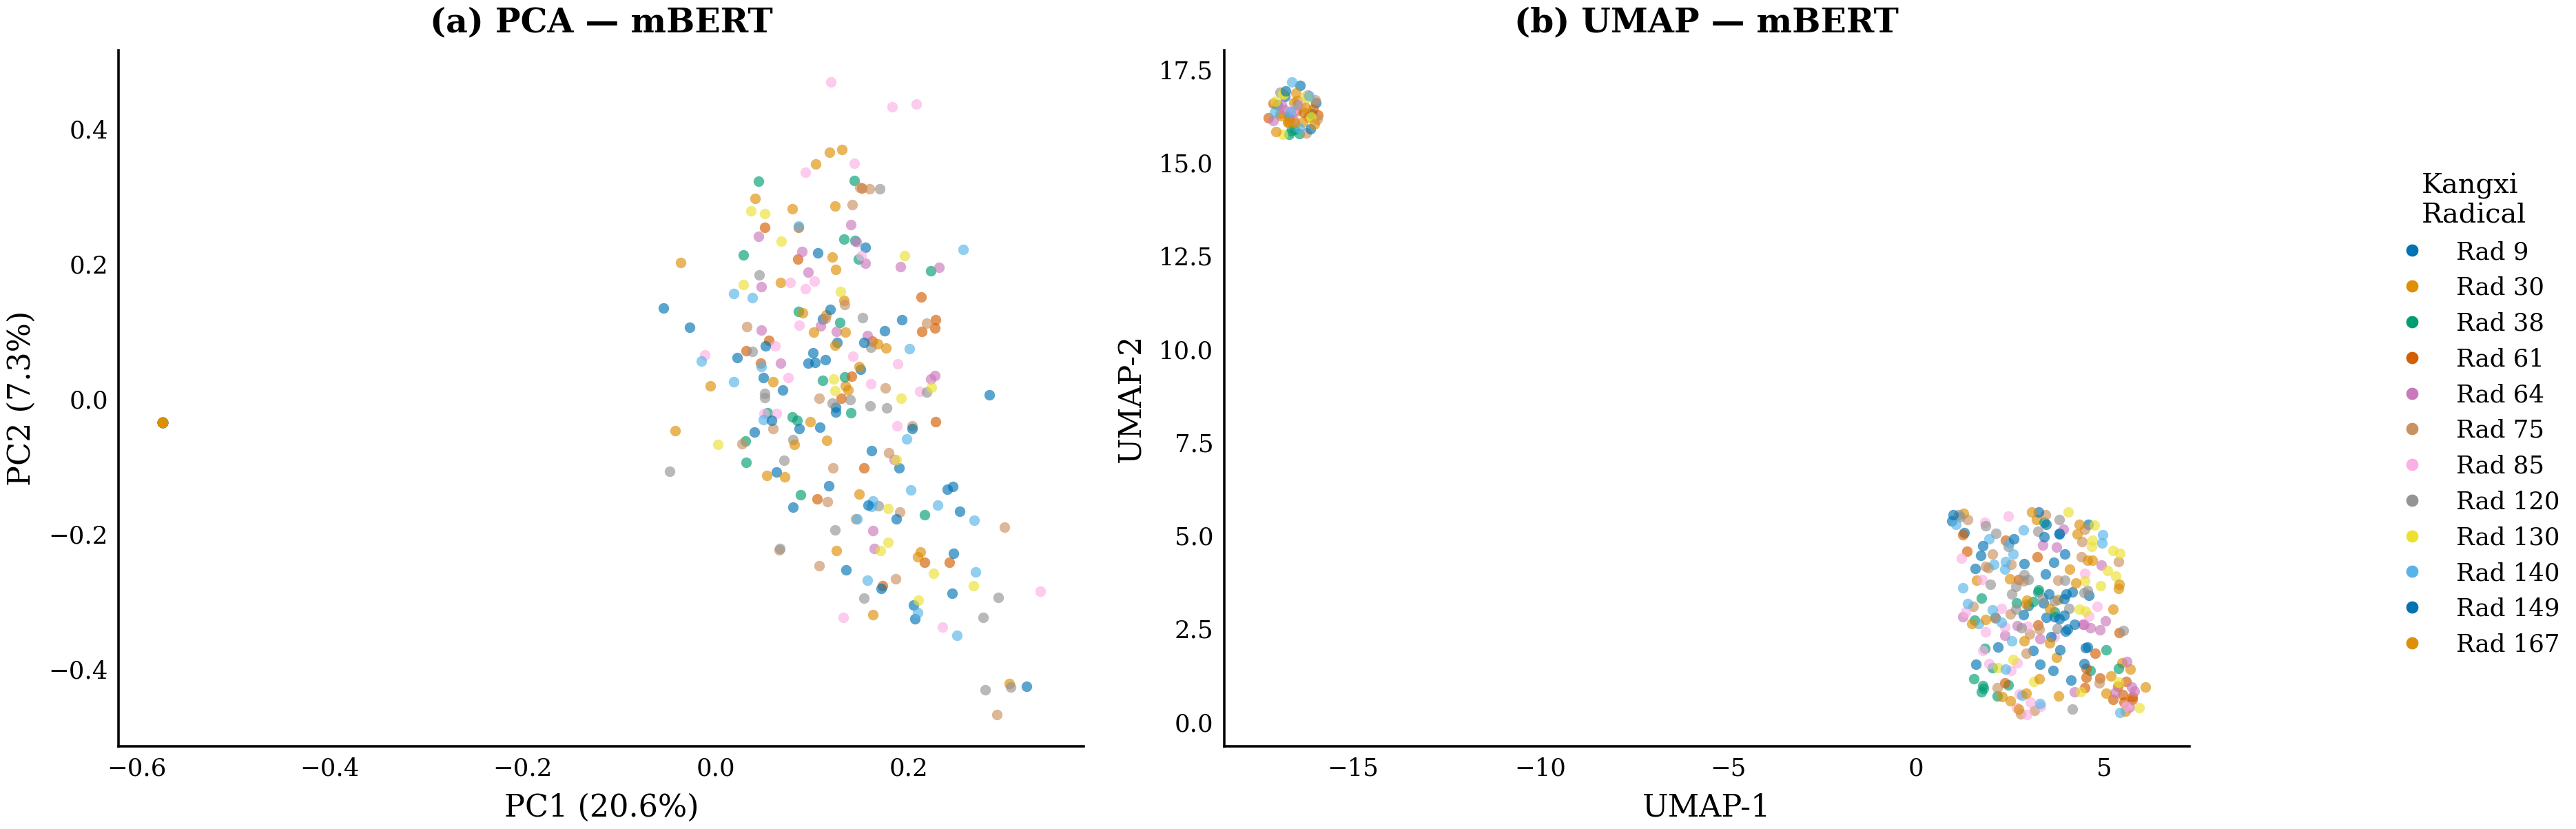

Saved fig1_geometry_mbert (.png + .pdf)


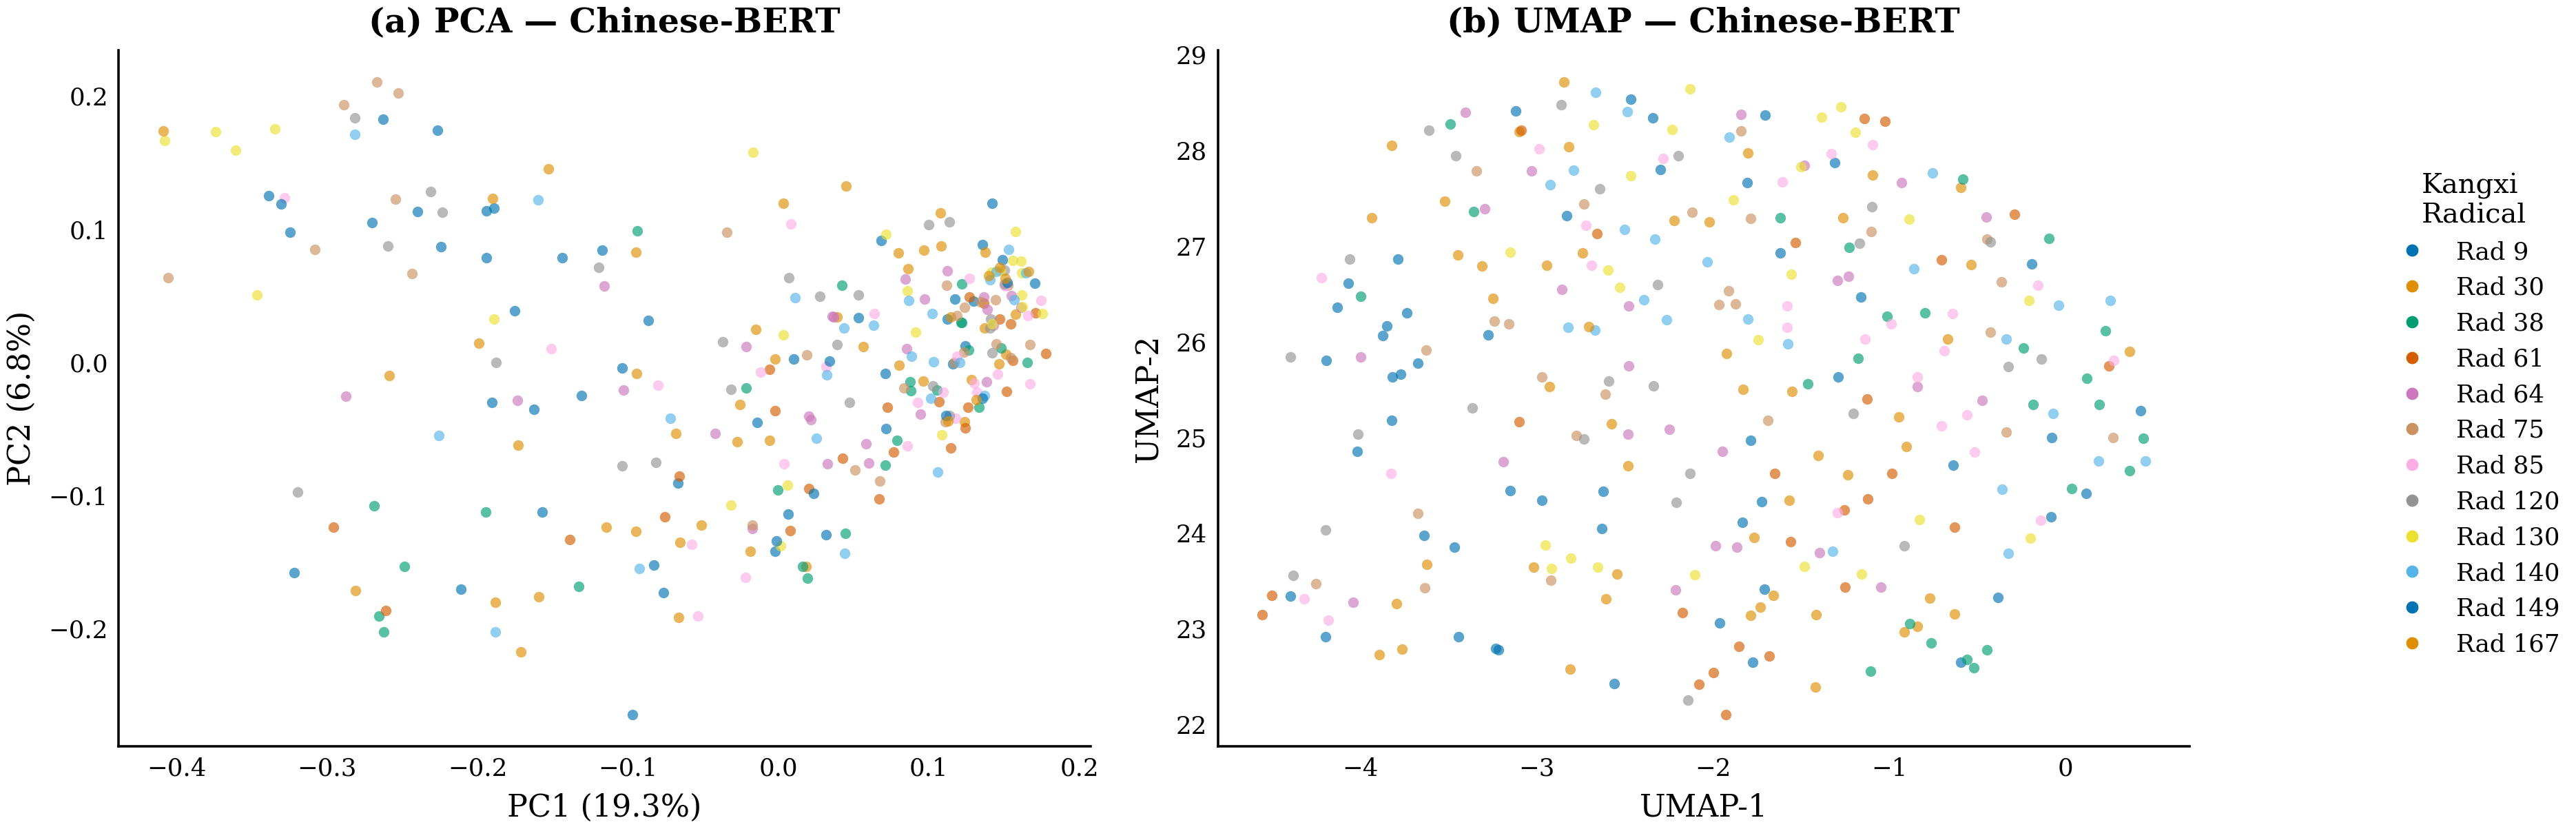

Saved fig1_geometry_chinesebert (.png + .pdf)


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from matplotlib.lines import Line2D

TOP_K = 12          # radicals to show (for legend readability)
PER_RAD = 25        # characters sampled per radical

def kernel_to_embedding(sim, k=64):
    """Spectral embedding from cosine similarity kernel."""
    sym = (sim + sim.T) / 2.0
    w, v = np.linalg.eigh(sym)
    idx = np.argsort(w)[::-1]
    w, v = w[idx], v[:, idx]
    w = np.maximum(w, 0.0)
    keep = np.where(w > 1e-10)[0][:k]
    return v[:, keep] * np.sqrt(w[keep])

def make_fig1(sim_matrix, model_tag, color_accent):
    # Get top-K radicals by frequency
    counts = ds["radical"].value_counts()
    eligible = counts[counts >= 20].index.tolist()
    top_rads = counts.loc[eligible].head(TOP_K).index.tolist()

    # Even sampling
    rng = np.random.default_rng(42)
    sample_idx = []
    for r in top_rads:
        rows = ds.index[ds["radical"] == r].to_numpy()
        take = min(PER_RAD, len(rows))
        sample_idx.extend(rng.choice(rows, size=take, replace=False).tolist())
    sample_idx = np.array(sample_idx, dtype=int)

    sub_sim = np.clip(sim_matrix[np.ix_(sample_idx, sample_idx)], -1, 1).astype(np.float64)
    np.fill_diagonal(sub_sim, 1.0)

    # PCA via spectral embedding
    Z = kernel_to_embedding(sub_sim, k=64)
    pca = PCA(n_components=2, random_state=42)
    Xp = pca.fit_transform(Z)

    # UMAP on precomputed distance
    dist = 1.0 - sub_sim
    np.fill_diagonal(dist, 0.0)
    um = umap.UMAP(n_components=2, metric="precomputed",
                    random_state=42, n_neighbors=15, min_dist=0.25)
    Xu = um.fit_transform(dist)

    labels = ds.loc[sample_idx, "radical"].astype(str).to_numpy()
    uniq = sorted(pd.unique(labels), key=lambda x: int(x))
    palette = sns.color_palette("colorblind", n_colors=len(uniq))
    cmap = {r: palette[i] for i, r in enumerate(uniq)}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.2, 4.0))

    for ax, X, title, xl, yl in [
        (ax1, Xp,
         f"(a) PCA — {model_tag}",
         f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
         f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)"),
        (ax2, Xu,
         f"(b) UMAP — {model_tag}",
         "UMAP-1", "UMAP-2"),
    ]:
        for r in uniq:
            m = (labels == r)
            ax.scatter(X[m, 0], X[m, 1], s=12, alpha=0.65,
                       linewidths=0, color=cmap[r], rasterized=True)
        ax.set_title(title, fontweight="bold")
        ax.set_xlabel(xl); ax.set_ylabel(yl)
        ax.tick_params(length=0)

    handles = [Line2D([0],[0], marker="o", color="w",
               markerfacecolor=cmap[r], markersize=5, label=f"Rad {r}")
               for r in uniq]
    fig.legend(handles=handles, loc="center right",
               bbox_to_anchor=(1.16, 0.5), frameon=False,
               title="Kangxi\nRadical", title_fontsize=9)
    plt.tight_layout()

    tag = model_tag.lower().replace("-","")
    for ext in [".png", ".pdf"]:
        plt.savefig(os.path.join(FIG_DIR, f"fig1_geometry_{tag}{ext}"))
    plt.show()
    print(f"Saved fig1_geometry_{tag} (.png + .pdf)")

make_fig1(m_sim, "mBERT", C_BLUE)
make_fig1(c_sim, "Chinese-BERT", C_RED)

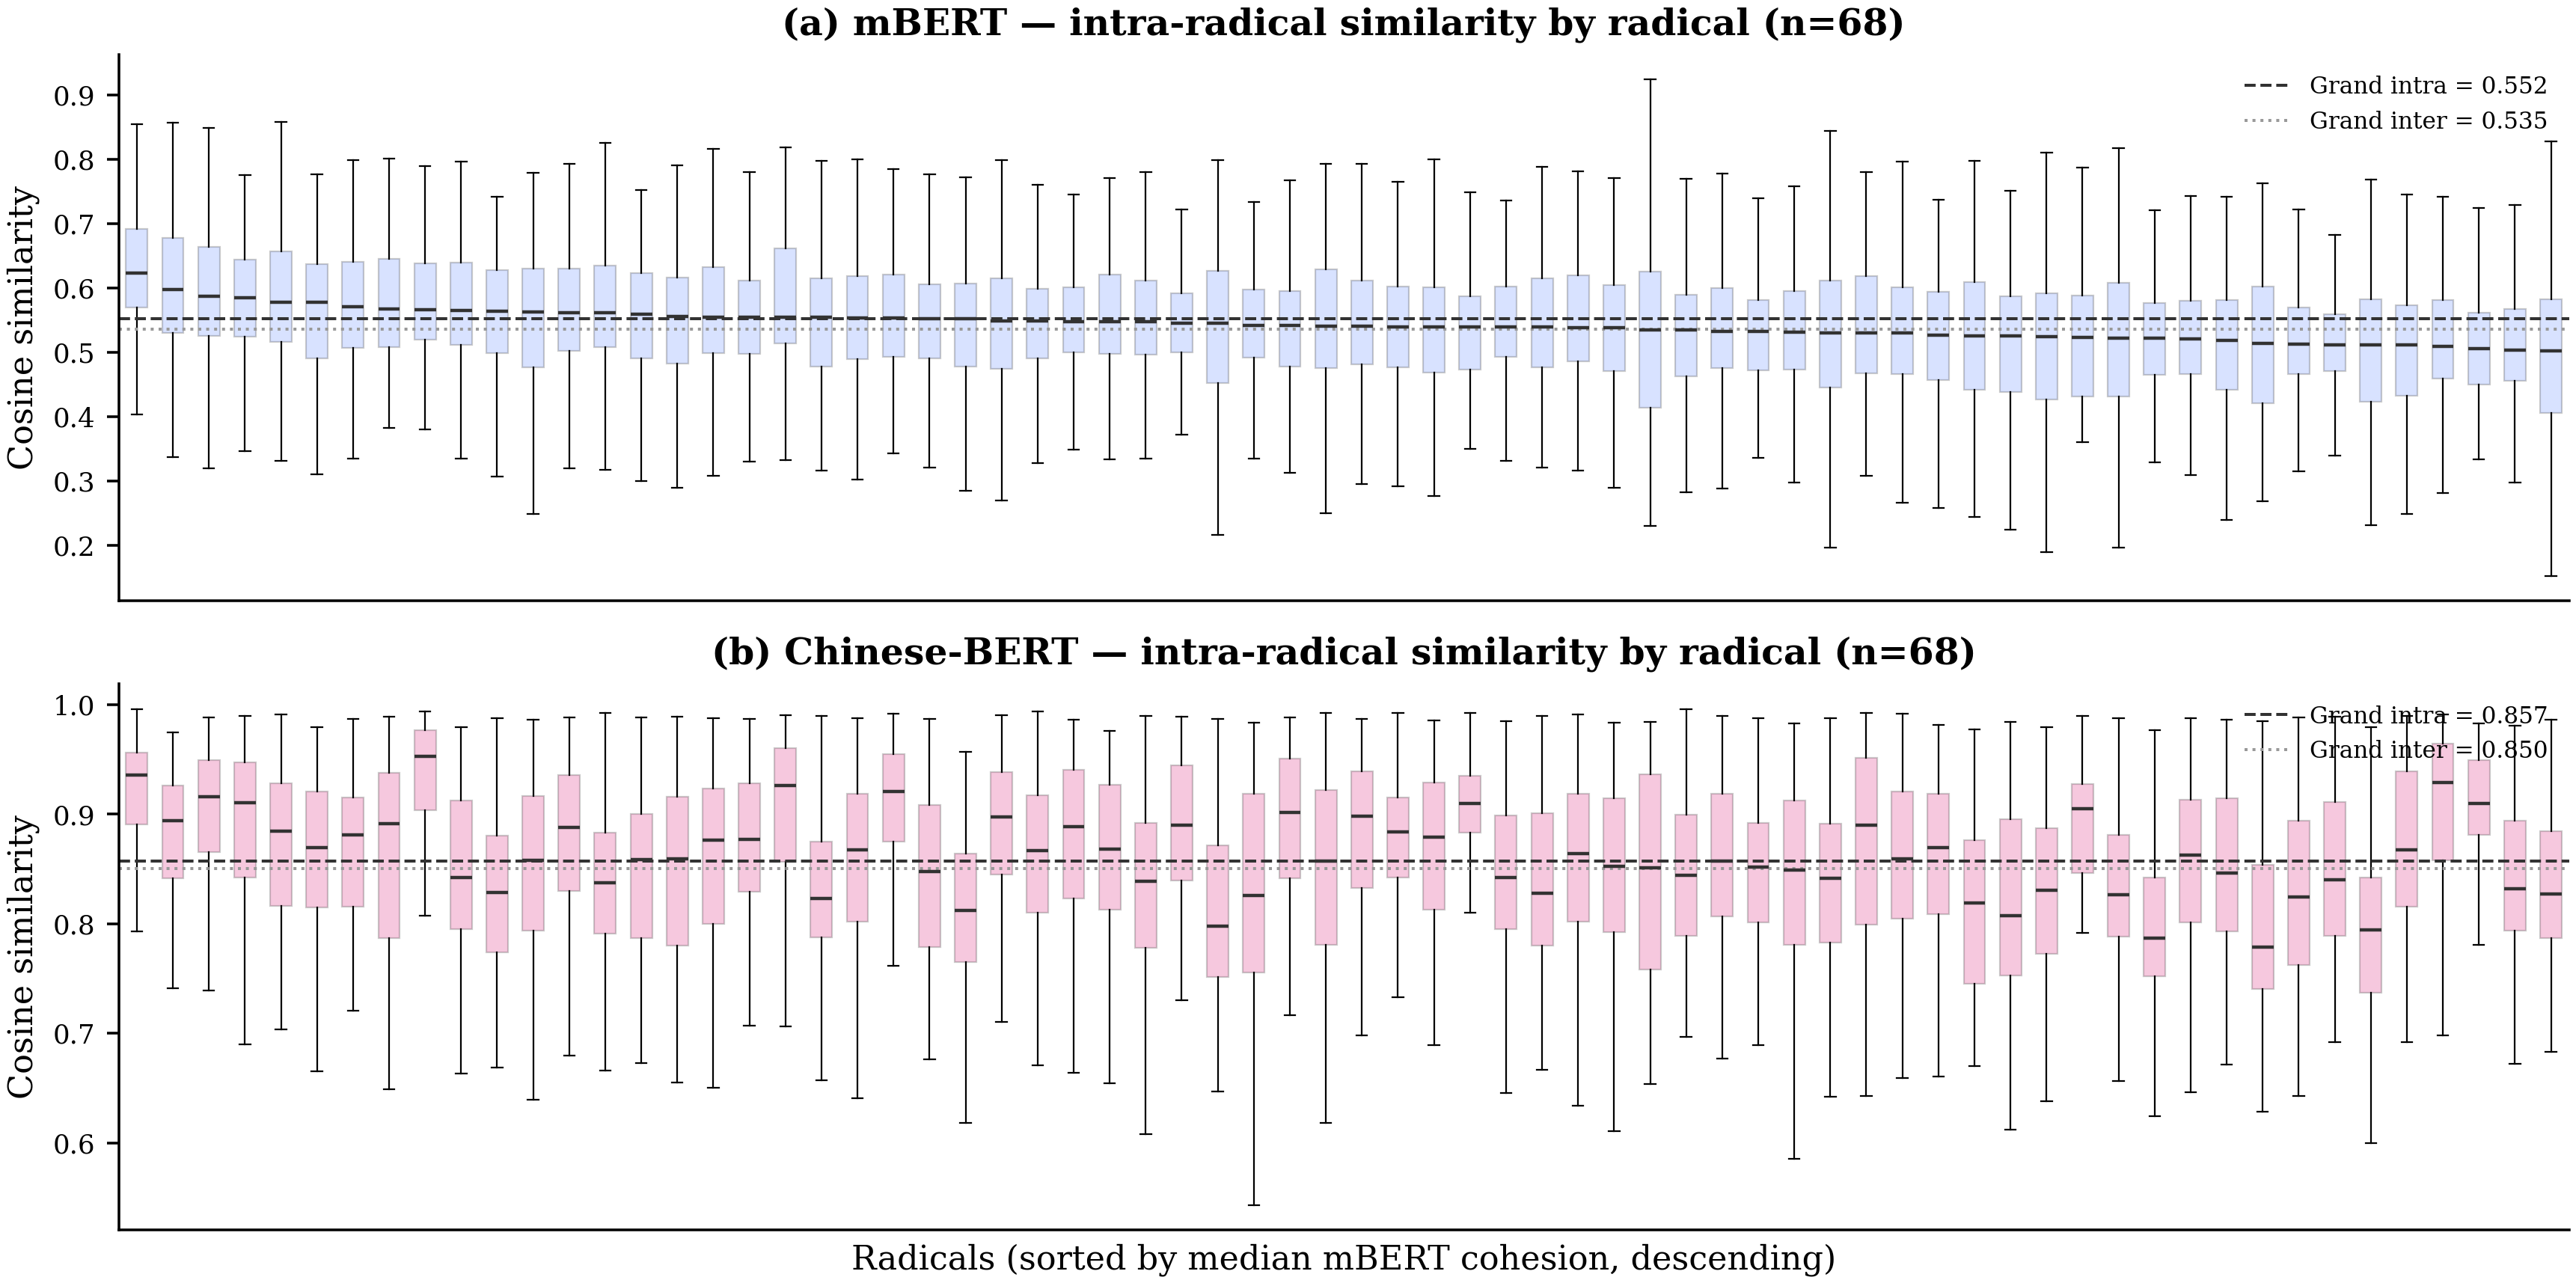

Saved fig2_per_radical_cohesion_box (.png + .pdf)


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MAX_PAIRS = 400  # per radical, for manageable computation

def sample_intra_sims(sim_matrix, min_size=20, max_pairs=MAX_PAIRS, seed=42):
    """Sample within-radical cosine similarities from saved sim matrix."""
    rng = np.random.default_rng(seed)
    groups = ds.groupby("radical").indices  # radical -> array of row indices
    out = {}
    for rad, idxs in groups.items():
        idxs = np.array(list(idxs), dtype=int)
        if len(idxs) < min_size:
            continue
        a = rng.choice(idxs, size=max_pairs, replace=True)
        b = rng.choice(idxs, size=max_pairs, replace=True)
        keep = a != b
        a, b = a[keep], b[keep]
        out[str(rad)] = sim_matrix[a, b].astype(np.float32)
    return out

m_by_rad = sample_intra_sims(m_sim)
c_by_rad = sample_intra_sims(c_sim)

# Sort radicals by median mBERT cohesion (descending)
meds = {r: float(np.median(v)) for r, v in m_by_rad.items()}
rad_order = sorted(meds, key=lambda r: meds[r], reverse=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.6), sharex=True)

for ax, by_rad, color, title, grand_intra, grand_inter in [
    (ax1, m_by_rad, C_BLUE, "(a) mBERT",
     float(np.mean(m_intra)), float(np.mean(m_inter))),
    (ax2, c_by_rad, C_RED, "(b) Chinese-BERT",
     float(np.mean(c_intra)), float(np.mean(c_inter))),
]:
    data = [by_rad.get(r, np.array([np.nan])) for r in rad_order]
    bp = ax.boxplot(
        data, vert=True, patch_artist=True, showfliers=False,
        widths=0.6,
        medianprops=dict(color=C_DARK, linewidth=1.0),
        boxprops=dict(linewidth=0.5),
        whiskerprops=dict(linewidth=0.5),
        capprops=dict(linewidth=0.5),
    )
    for patch in bp["boxes"]:
        patch.set_facecolor(color)
        patch.set_alpha(0.25)
        patch.set_edgecolor(C_DARK)

    ax.axhline(grand_intra, color=C_DARK, ls="--", lw=0.9,
               label=f"Grand intra = {grand_intra:.3f}")
    ax.axhline(grand_inter, color=C_GRAY, ls=":", lw=0.9,
               label=f"Grand inter = {grand_inter:.3f}")
    ax.set_title(f"{title} — intra-radical similarity by radical (n={len(rad_order)})",
                 fontweight="bold")
    ax.set_ylabel("Cosine similarity")
    ax.legend(frameon=False, loc="upper right", fontsize=7)
    ax.set_xticks([])

ax2.set_xlabel("Radicals (sorted by median mBERT cohesion, descending)")
plt.tight_layout()
for ext in [".png", ".pdf"]:
    plt.savefig(os.path.join(FIG_DIR, f"fig2_per_radical_cohesion_box{ext}"))
plt.show()
print("Saved fig2_per_radical_cohesion_box (.png + .pdf)")

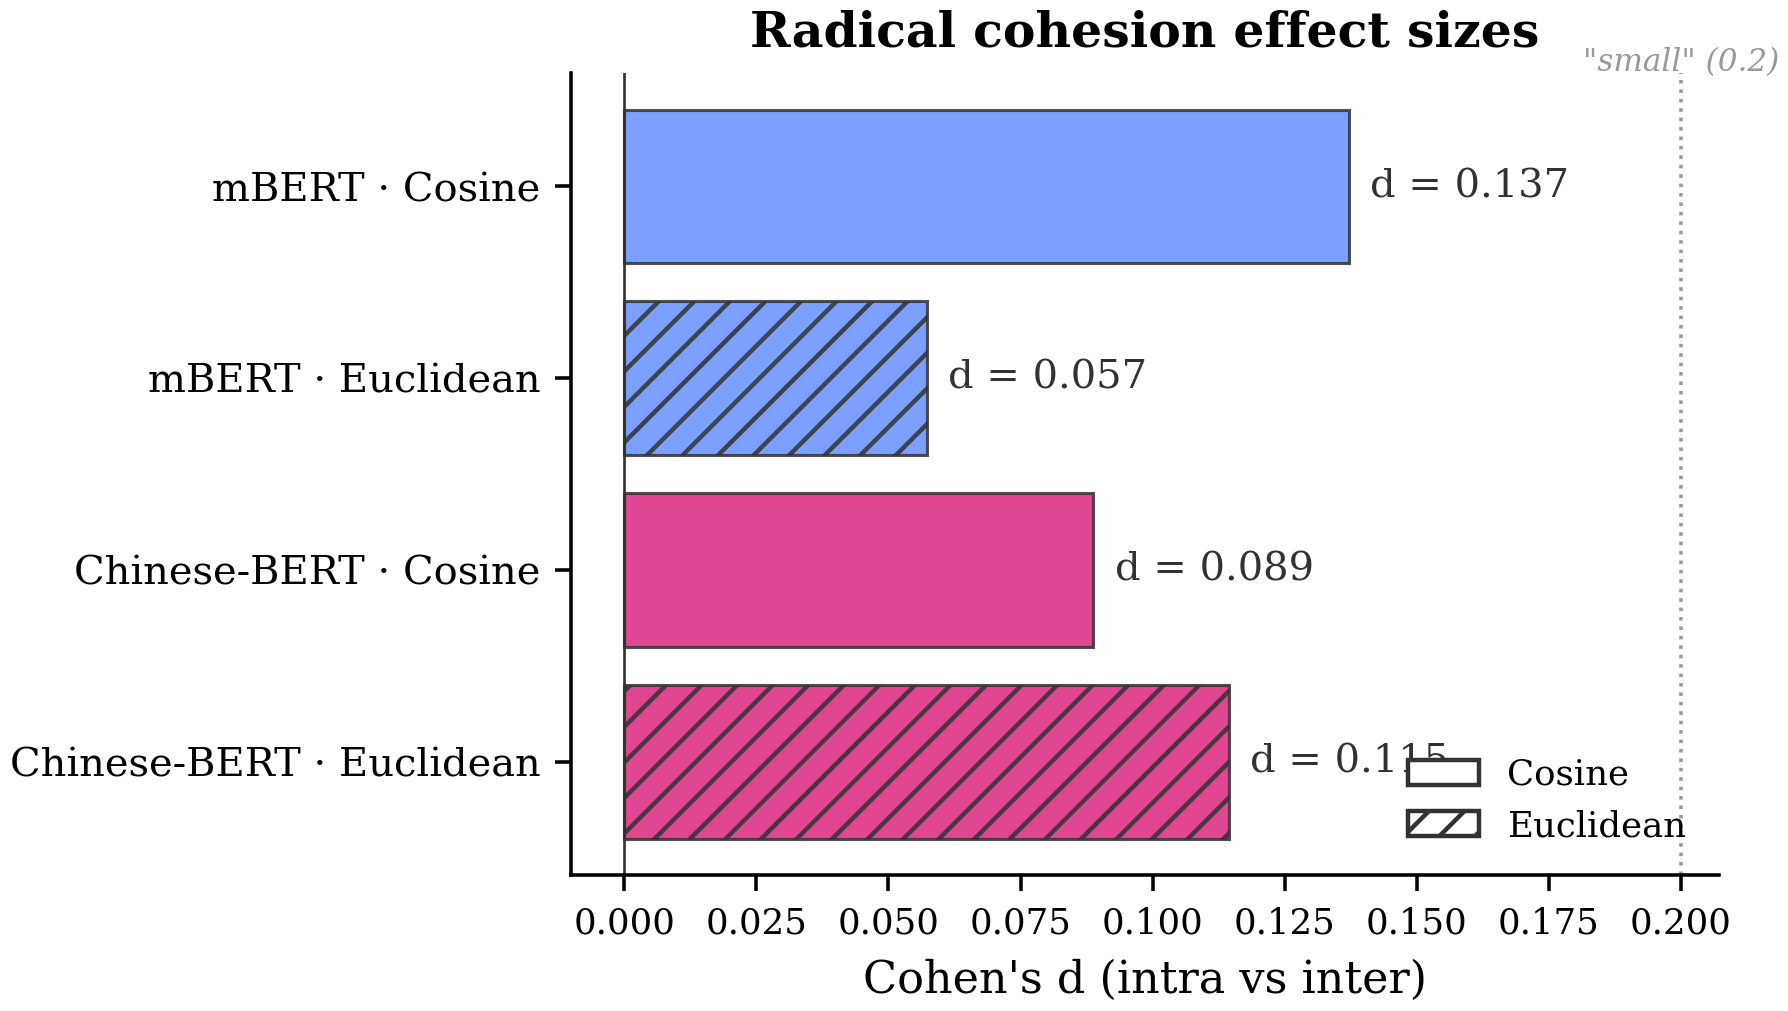

Saved fig3_effect_size (.png + .pdf)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# main_results.csv is WIDE format — one row per model, separate Cos_* and Euc_* columns
# Columns: Model, Cos_d, Euc_d, Cos_CI_lo, Cos_CI_hi, Euc_CI_lo, Euc_CI_hi, ...
mbert_row  = main_df[main_df["Model"] == "mBERT"].iloc[0]
chbert_row = main_df[main_df["Model"] == "Chinese-BERT"].iloc[0]

labels = [
    "mBERT · Cosine",
    "mBERT · Euclidean",
    "Chinese-BERT · Cosine",
    "Chinese-BERT · Euclidean",
]
d_vals = [
    float(mbert_row["Cos_d"]),
    float(mbert_row["Euc_d"]),
    float(chbert_row["Cos_d"]),
    float(chbert_row["Euc_d"]),
]
ci_lo = [
    float(mbert_row["Cos_CI_lo"]),
    float(mbert_row["Euc_CI_lo"]),
    float(chbert_row["Cos_CI_lo"]),
    float(chbert_row["Euc_CI_lo"]),
]
ci_hi = [
    float(mbert_row["Cos_CI_hi"]),
    float(mbert_row["Euc_CI_hi"]),
    float(chbert_row["Cos_CI_hi"]),
    float(chbert_row["Euc_CI_hi"]),
]
colors  = [C_BLUE, C_BLUE, C_RED, C_RED]
hatches = ["", "///", "", "///"]

y = np.arange(len(d_vals))

fig, ax = plt.subplots(figsize=(5.8, 3.4))
bars = ax.barh(y, d_vals, color=colors, edgecolor=C_DARK, linewidth=0.7, alpha=0.85)
for b, h in zip(bars, hatches):
    b.set_hatch(h)

# CI whiskers
for i in range(len(d_vals)):
    # CI is on the Δ (intra-inter), not on d directly.
    # Show d value as text instead.
    ax.text(d_vals[i] + 0.004, y[i], f"d = {d_vals[i]:.3f}",
            va="center", ha="left", fontsize=9, color=C_DARK)

ax.axvline(0, color=C_DARK, linewidth=0.6)
ax.axvline(0.2, color=C_GRAY, linestyle=":", linewidth=0.8)
ax.text(0.2, -0.6, "\"small\" (0.2)", ha="center", fontsize=7,
        color=C_GRAY, style="italic")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel("Cohen's d (intra vs inter)")
ax.set_title("Radical cohesion effect sizes", fontweight="bold")
ax.set_xlim(-0.01, max(d_vals) + 0.07)
ax.invert_yaxis()

ax.legend(
    handles=[
        Patch(facecolor="white", edgecolor=C_DARK, label="Cosine"),
        Patch(facecolor="white", edgecolor=C_DARK, hatch="///", label="Euclidean"),
    ],
    frameon=False, loc="lower right",
)
plt.tight_layout()
for ext in [".png", ".pdf"]:
    plt.savefig(os.path.join(FIG_DIR, f"fig3_effect_size{ext}"))
plt.show()
print("Saved fig3_effect_size (.png + .pdf)")

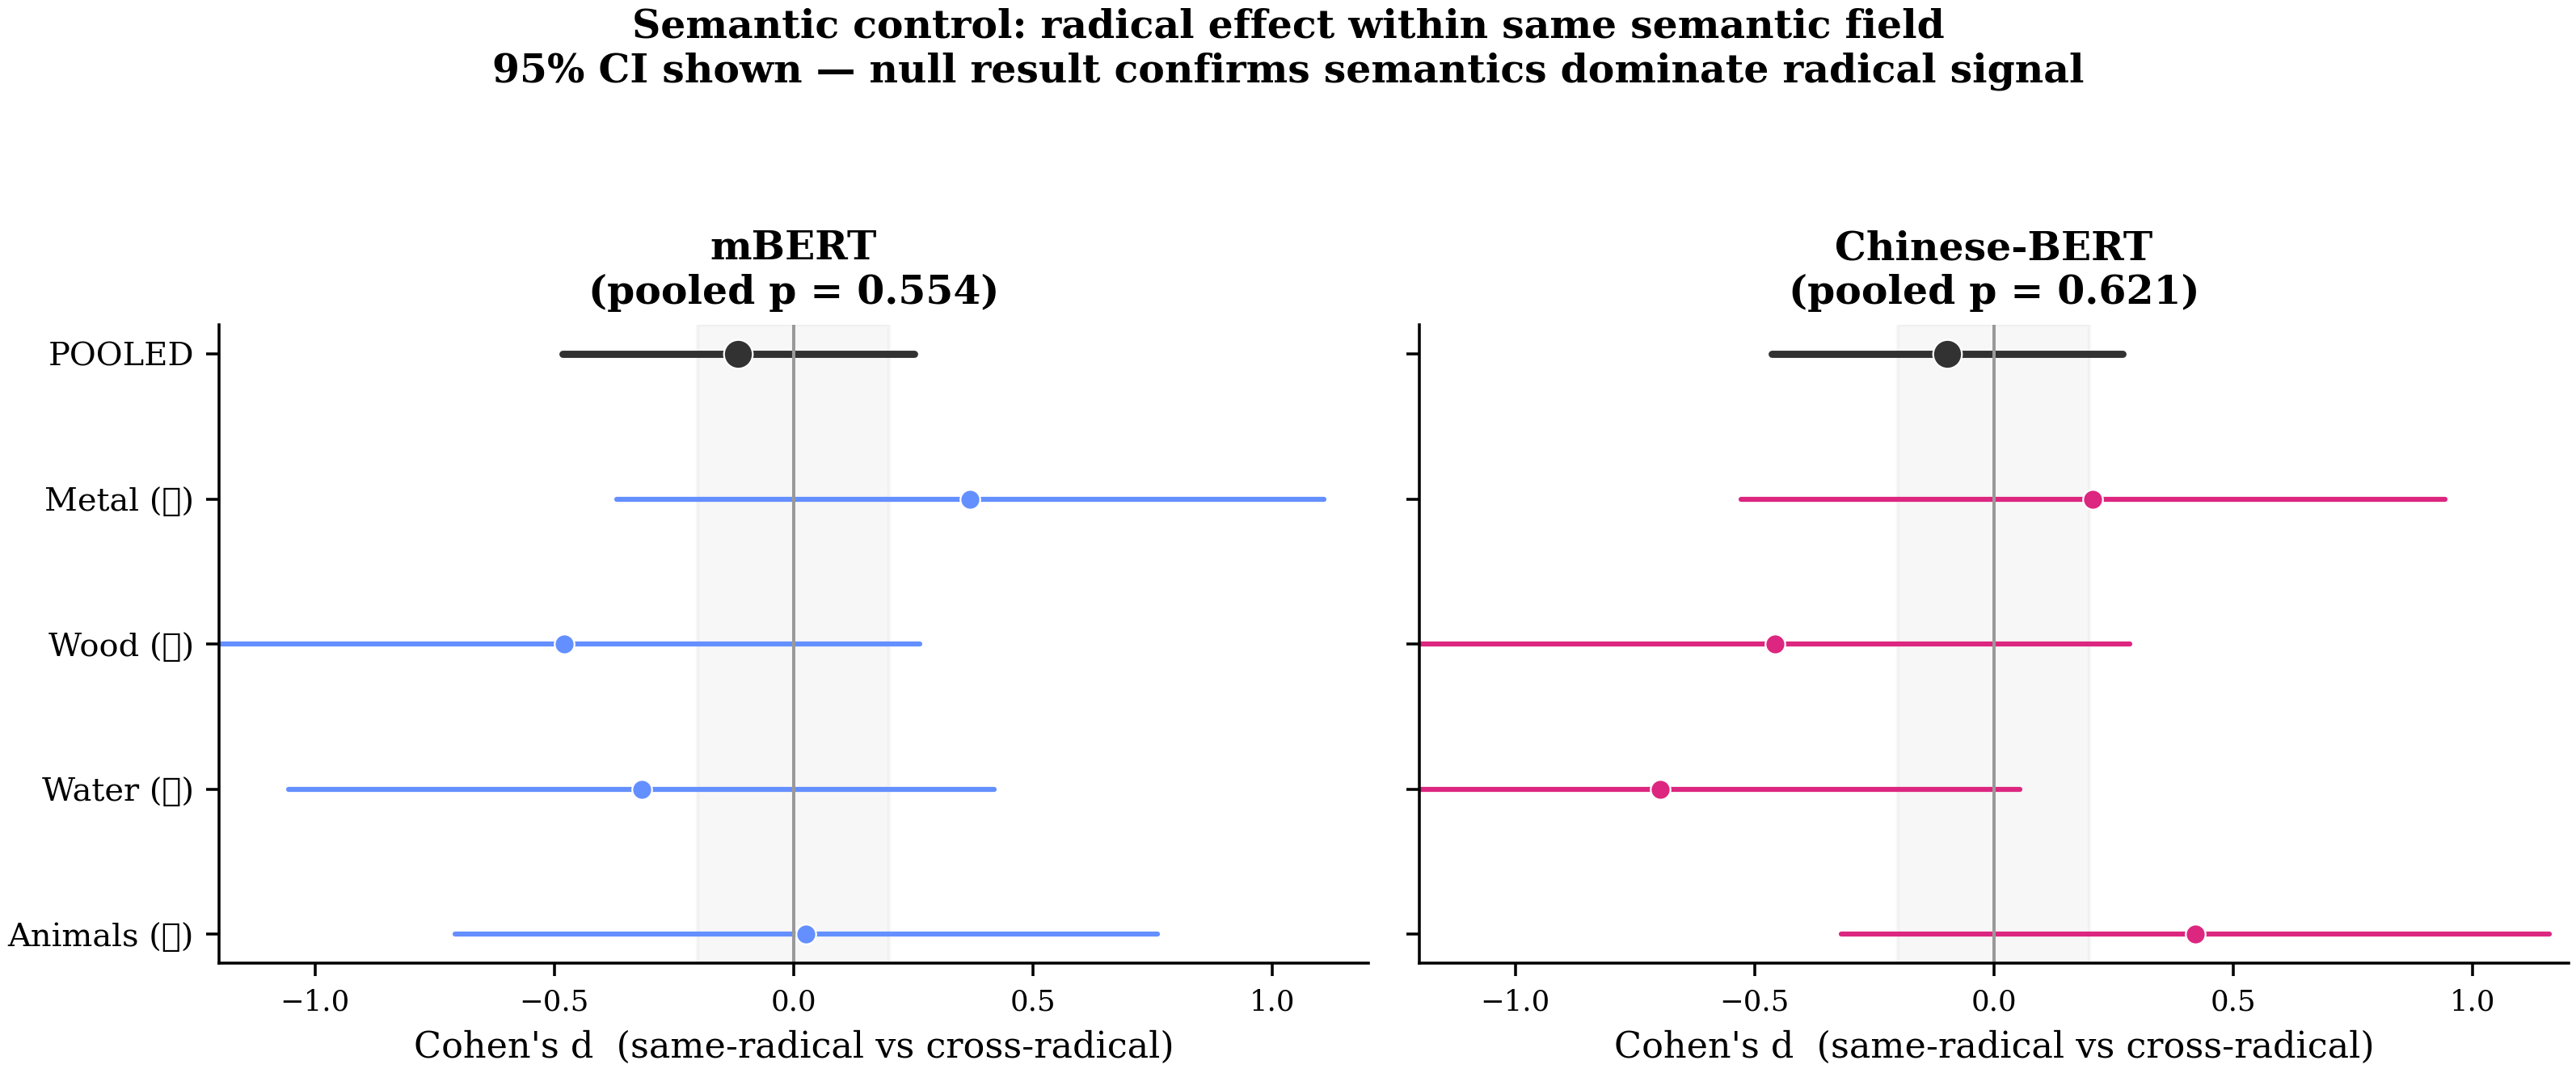

Saved fig4_semantic_control_forest (.png + .pdf)


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# sem_df columns: Model, Field, Radical, Intra, Cross, p, d
# Fields: animals_犭, water_氵, wood_木, metal_钅, POOLED
# Per field: n_intra=10 (C(5,2)), n_cross=25 (5x5)
# POOLED:    n_intra=40, n_cross=100

def approx_ci(d, n1, n2, alpha=0.05):
    se = np.sqrt((n1+n2)/(n1*n2) + d**2/(2*(n1+n2)))
    z = norm.ppf(1 - alpha/2)
    return d - z*se, d + z*se

models = ["mBERT", "Chinese-BERT"]
colors_map = {"mBERT": C_BLUE, "Chinese-BERT": C_RED}

fig, axes = plt.subplots(1, 2, figsize=(10.2, 4.0), sharey=True)

for ax, model in zip(axes, models):
    sub = sem_df[sem_df["Model"] == model].copy()

    # Ensure POOLED is last
    is_pooled = sub["Field"].str.upper() == "POOLED"
    sub = pd.concat([sub[~is_pooled], sub[is_pooled]]).reset_index(drop=True)

    y = np.arange(len(sub))
    dvals = sub["d"].astype(float).to_numpy()
    fields = sub["Field"].astype(str).tolist()

    for i in range(len(sub)):
        pooled = fields[i].upper() == "POOLED"
        n1 = 40 if pooled else 10
        n2 = 100 if pooled else 25
        lo, hi = approx_ci(dvals[i], n1, n2)

        c = C_DARK if pooled else colors_map[model]
        ms = 8 if pooled else 5.5
        lw = 2.0 if pooled else 1.4

        ax.plot([lo, hi], [y[i], y[i]], color=c, linewidth=lw,
                solid_capstyle="round")
        ax.plot(dvals[i], y[i], "o", color=c, markersize=ms,
                markeredgecolor="white", markeredgewidth=0.5)

    # Zero line + negligible-effect shading
    ax.axvline(0, color=C_GRAY, linewidth=0.9)
    ax.axvspan(-0.2, 0.2, color=C_GRAY, alpha=0.07)

    # Retrieve pooled stats for subtitle
    pooled_row = sub[sub["Field"].str.upper() == "POOLED"].iloc[0]
    pooled_p = float(pooled_row["p"])

    ax.set_title(f"{model}\n(pooled p = {pooled_p:.3f})", fontweight="bold")
    ax.set_xlabel("Cohen's d  (same-radical vs cross-radical)")
    ax.set_yticks(y)

    # Clean field labels
    display = []
    for f in fields:
        if f.upper() == "POOLED":
            display.append("POOLED")
        else:
            parts = f.split("_")
            display.append(f"{parts[0].capitalize()} ({parts[1]})" if len(parts) > 1 else f)
    ax.set_yticklabels(display, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlim(-1.2, 1.2)

fig.suptitle(
    "Semantic control: radical effect within same semantic field\n"
    "95% CI shown — null result confirms semantics dominate radical signal",
    fontweight="bold", fontsize=11, y=1.06,
)
plt.tight_layout()
for ext in [".png", ".pdf"]:
    plt.savefig(os.path.join(FIG_DIR, f"fig4_semantic_control_forest{ext}"))
plt.show()
print("Saved fig4_semantic_control_forest (.png + .pdf)")

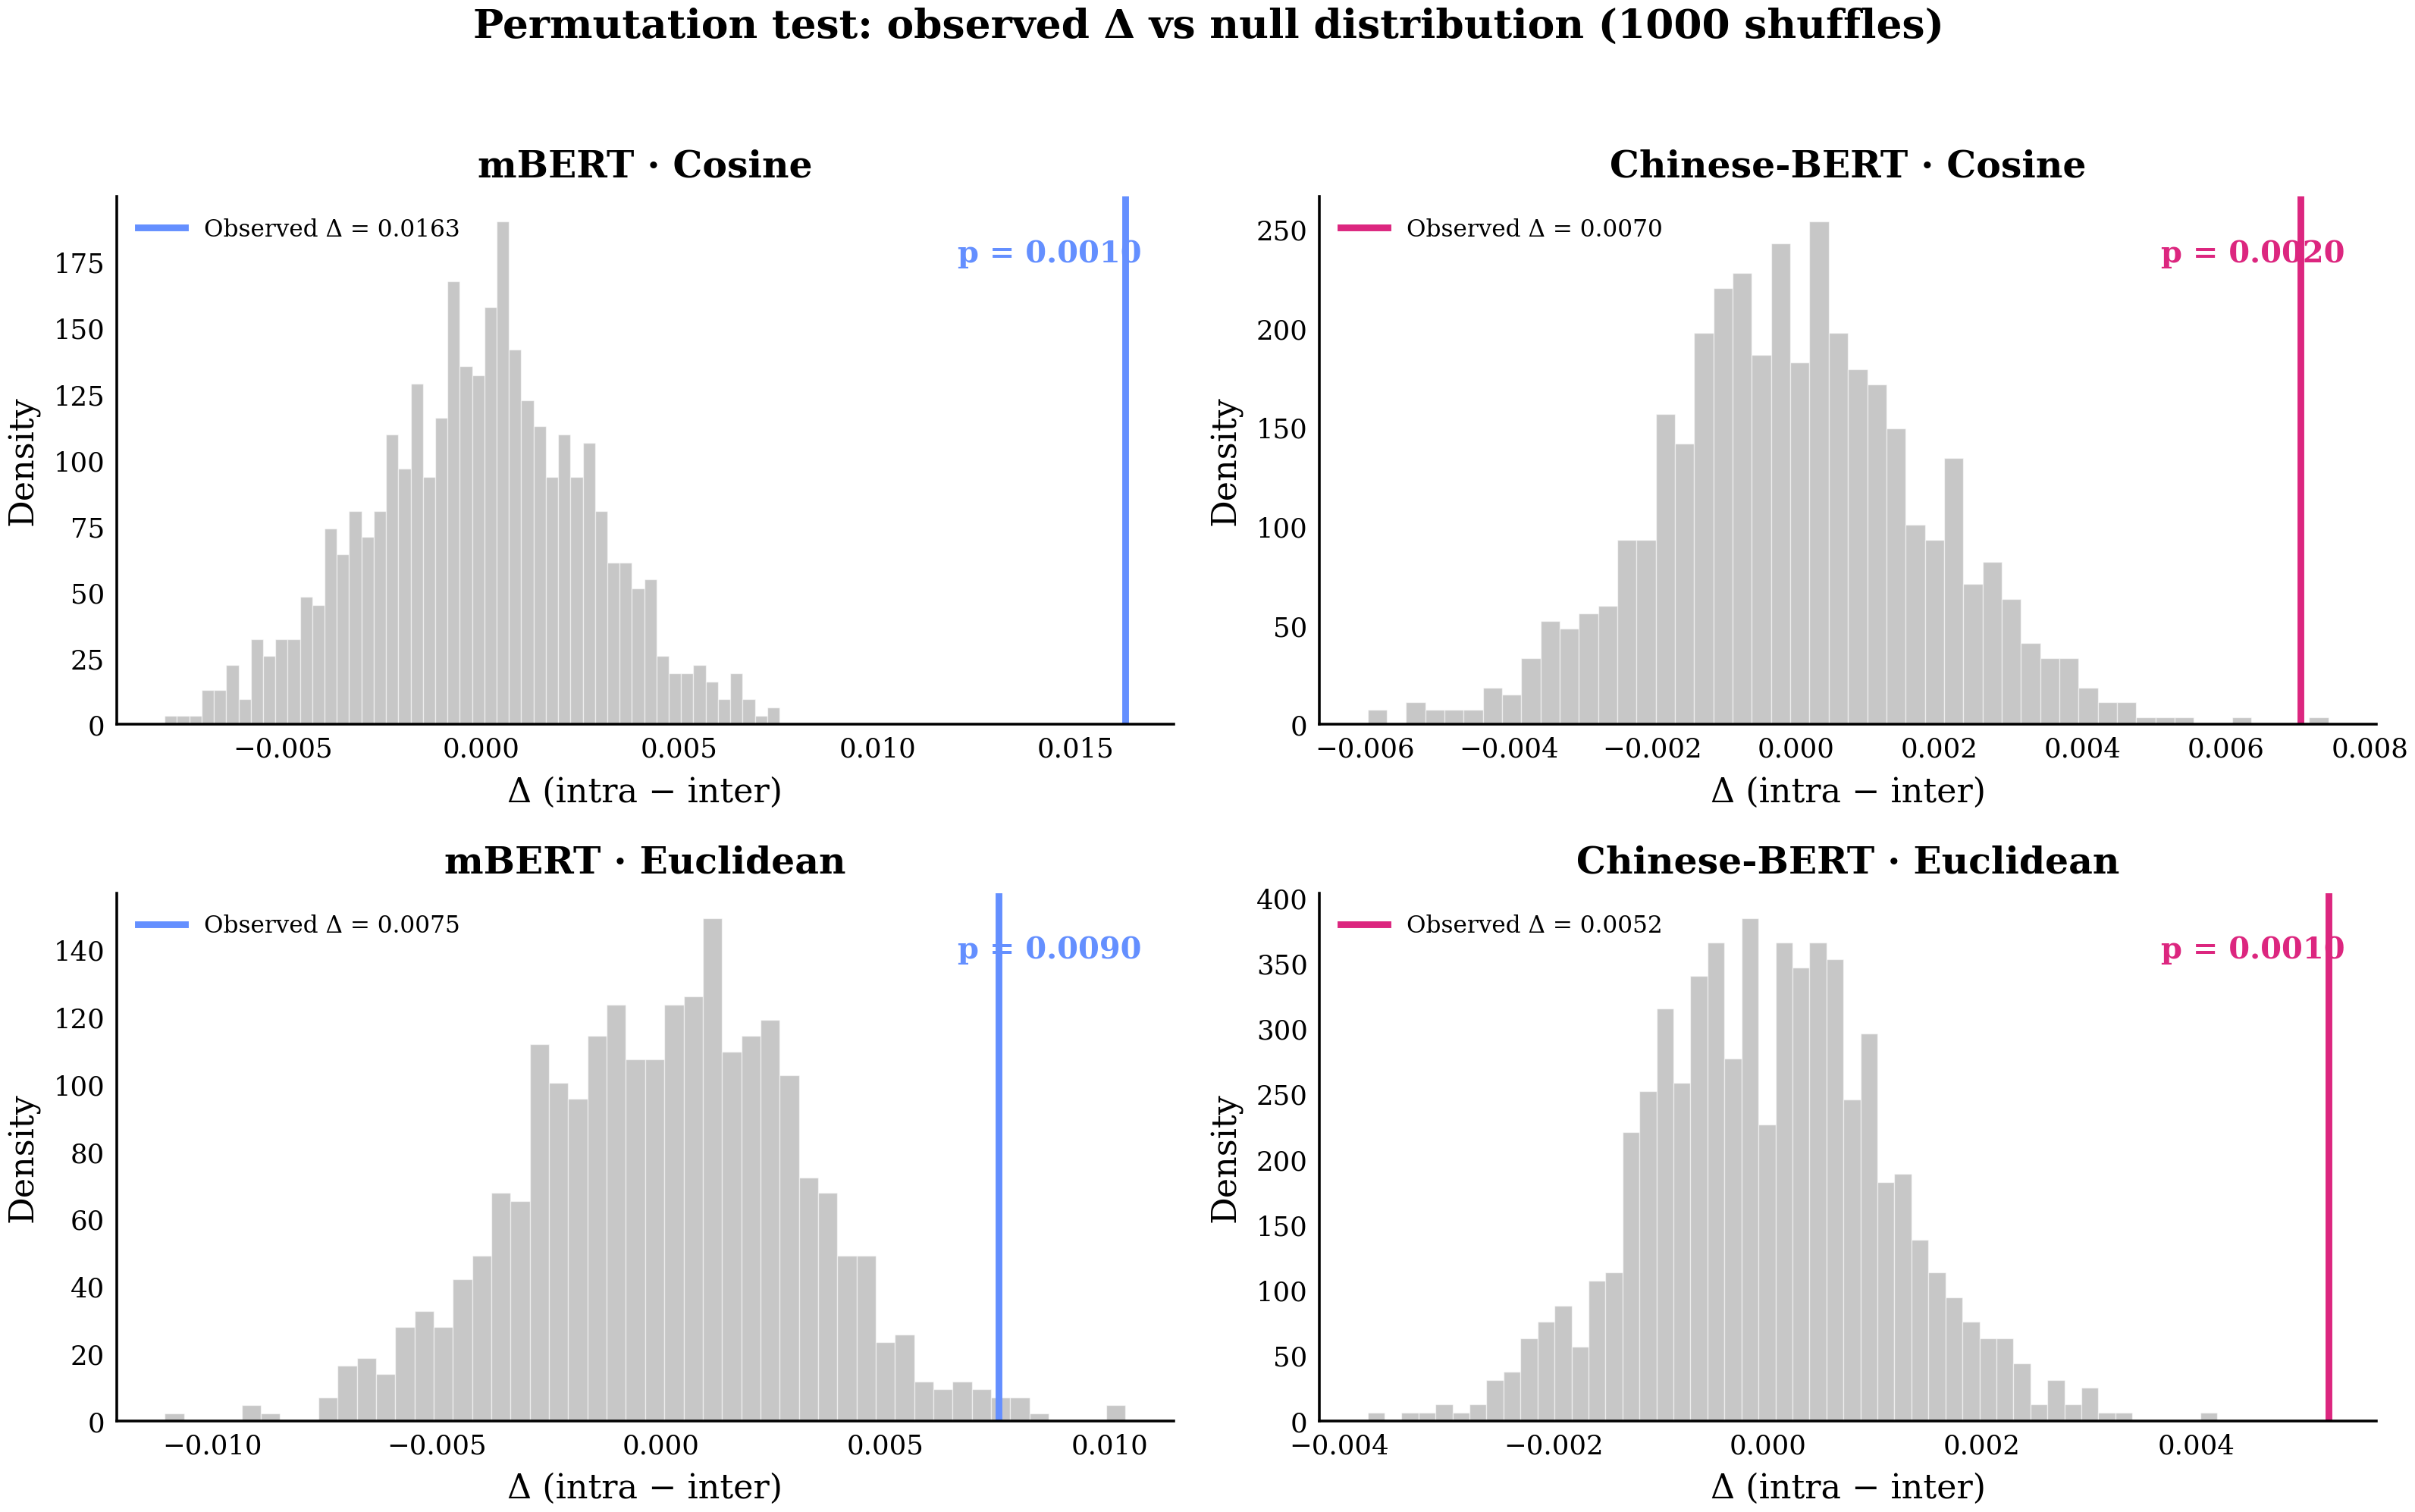

Saved fig5_permutation (.png + .pdf)


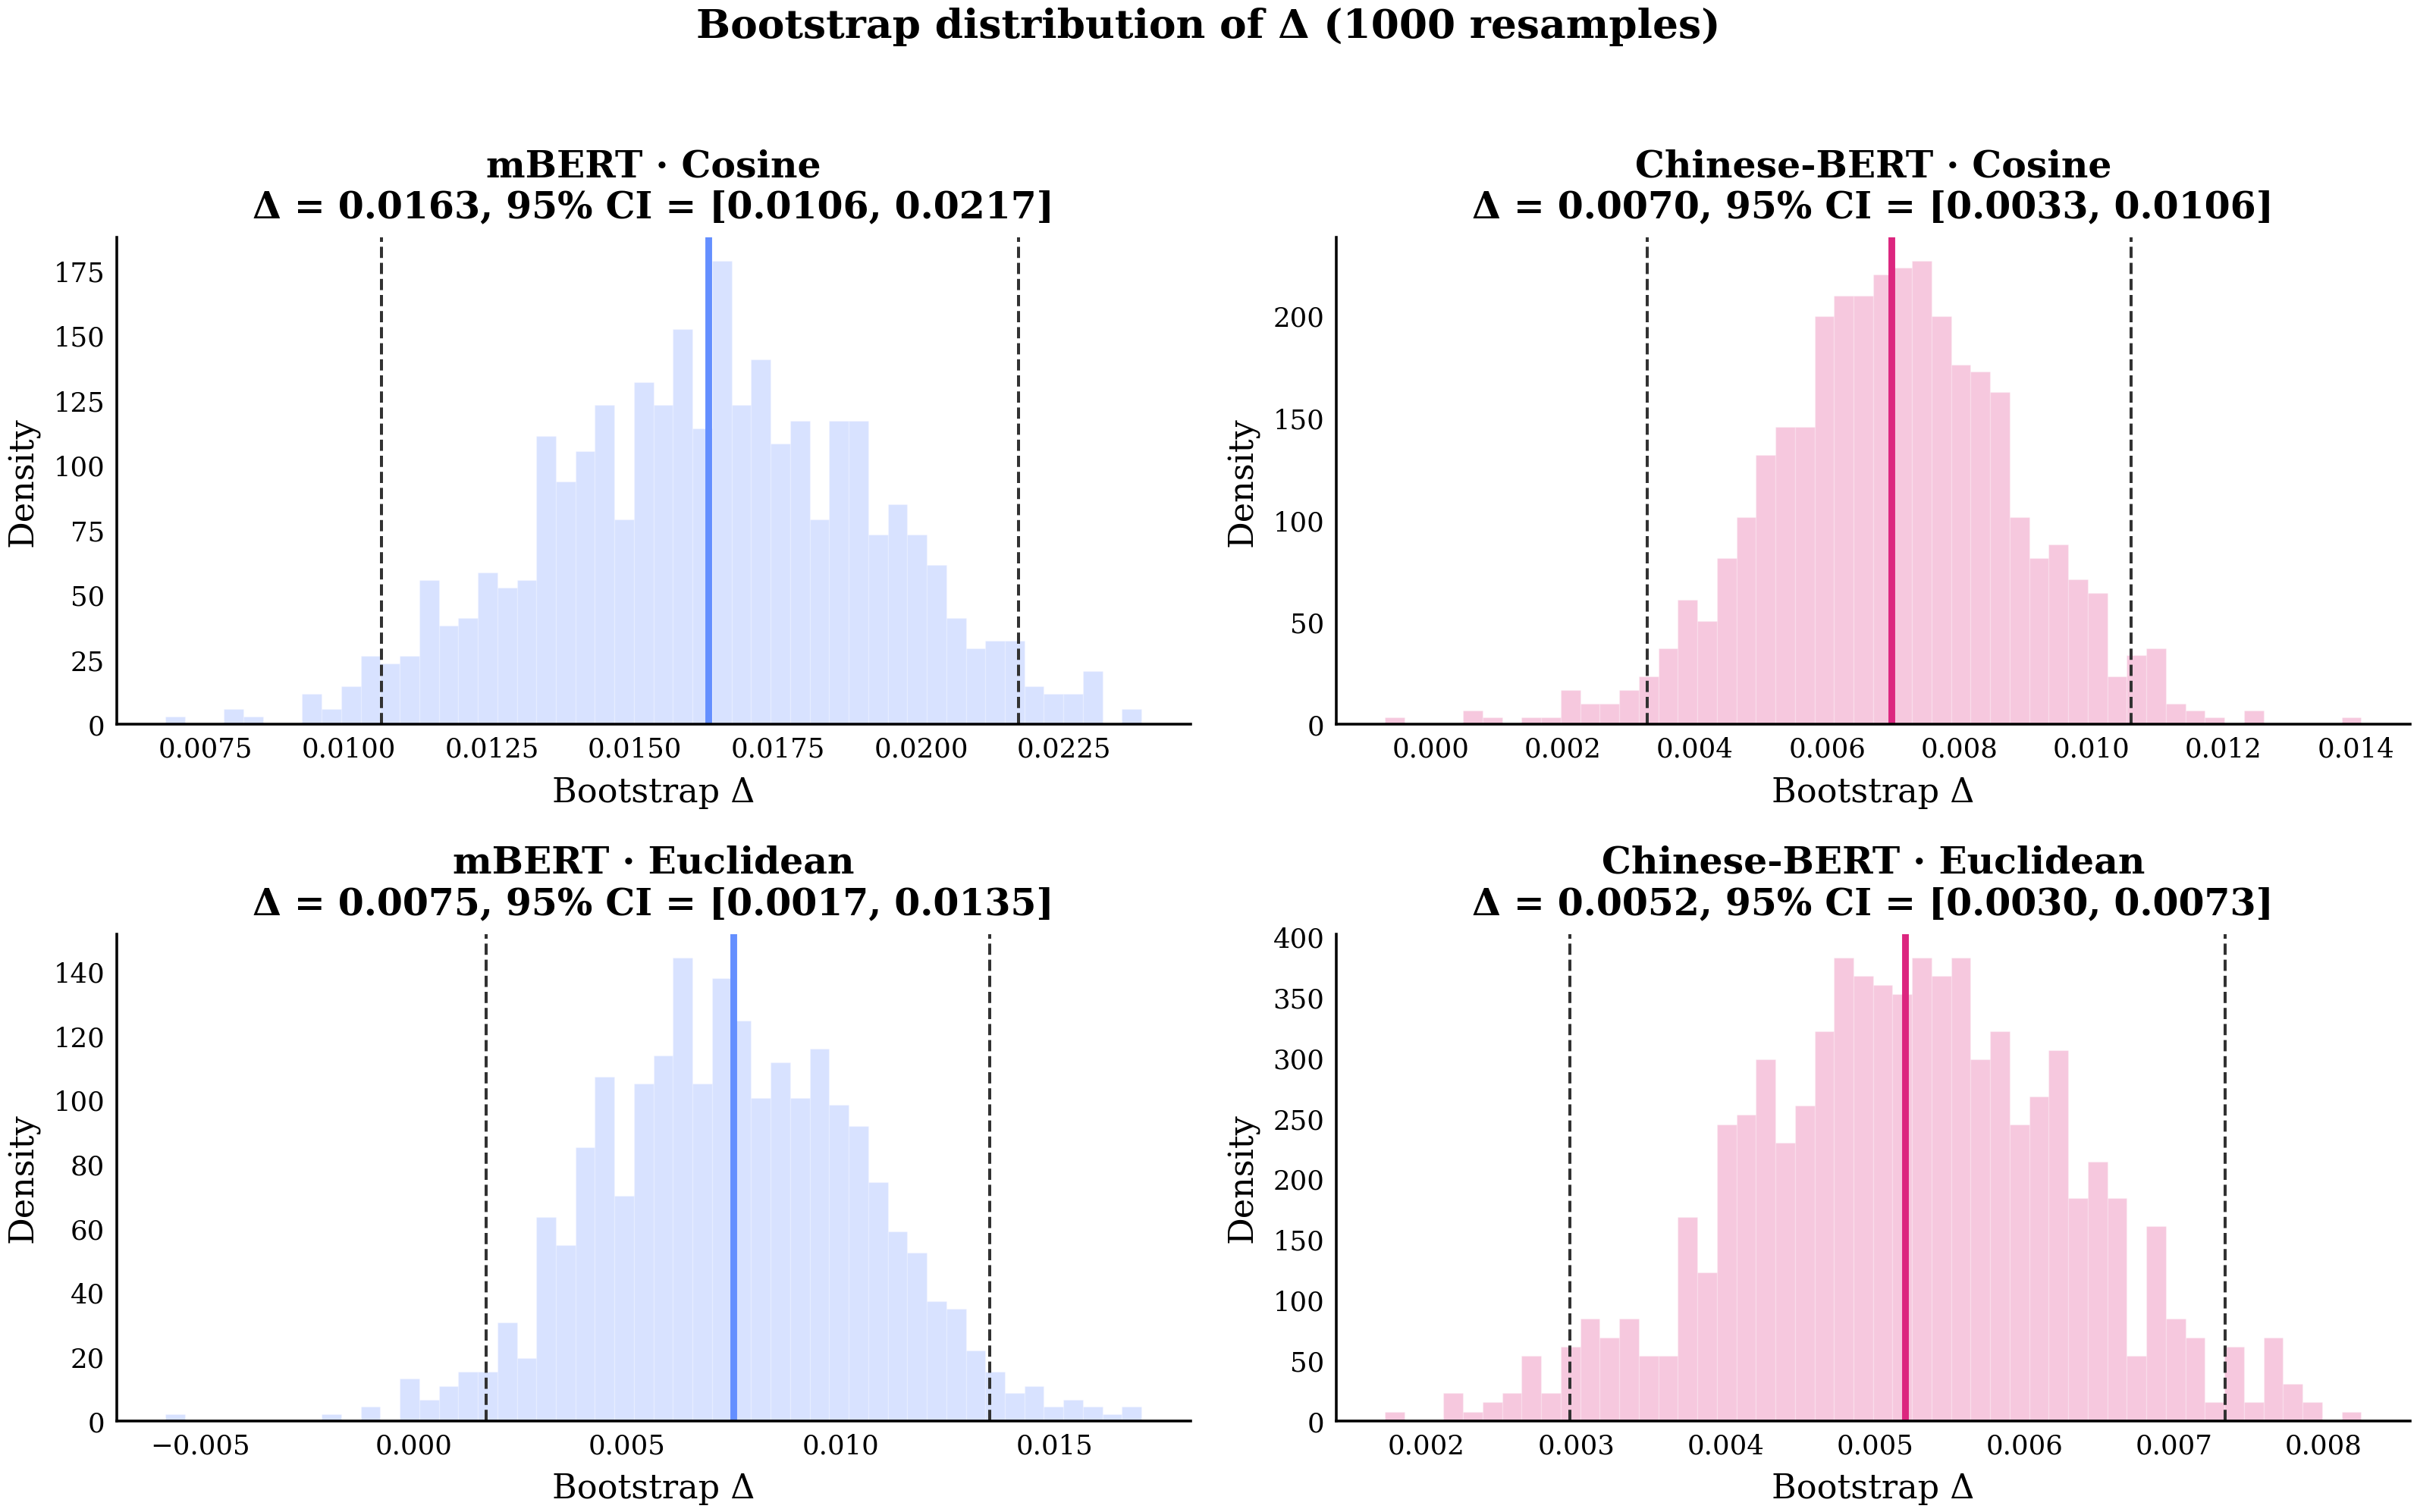

Saved fig6_bootstrap (.png + .pdf)


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ── Panel A: Permutation null distributions (2×2) ──

def perm_panel(ax, perm, observed, title, color):
    ax.hist(perm, bins=50, density=True, color=C_GRAY,
            alpha=0.55, edgecolor="white", linewidth=0.3)
    ax.axvline(observed, color=color, linewidth=2.0, label=f"Observed Δ = {observed:.4f}")
    p = (np.sum(perm >= observed) + 1) / (len(perm) + 1)
    ax.text(0.97, 0.92, f"p = {p:.4f}", transform=ax.transAxes,
            ha="right", va="top", fontsize=9, fontweight="bold", color=color)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Δ (intra − inter)")
    ax.set_ylabel("Density")
    ax.legend(frameon=False, fontsize=7, loc="upper left")
    ax.tick_params(length=0)

m_obs   = float(np.mean(m_intra)   - np.mean(m_inter))
c_obs   = float(np.mean(c_intra)   - np.mean(c_inter))
m_e_obs = float(np.mean(m_e_intra) - np.mean(m_e_inter))
c_e_obs = float(np.mean(c_e_intra) - np.mean(c_e_inter))

fig, axes = plt.subplots(2, 2, figsize=(10.2, 6.2))
perm_panel(axes[0,0], m_perm,   m_obs,   "mBERT · Cosine",            C_BLUE)
perm_panel(axes[0,1], c_perm,   c_obs,   "Chinese-BERT · Cosine",     C_RED)
perm_panel(axes[1,0], m_e_perm, m_e_obs, "mBERT · Euclidean",         C_BLUE)
perm_panel(axes[1,1], c_e_perm, c_e_obs, "Chinese-BERT · Euclidean",  C_RED)
fig.suptitle("Permutation test: observed Δ vs null distribution (1000 shuffles)",
             fontweight="bold", y=1.02)
plt.tight_layout()
for ext in [".png", ".pdf"]:
    plt.savefig(os.path.join(FIG_DIR, f"fig5_permutation{ext}"))
plt.show()
print("Saved fig5_permutation (.png + .pdf)")

# ── Panel B: Bootstrap Δ distributions (2×2) ──

def boot_panel(ax, boot, title, color):
    lo, hi = np.percentile(boot, [2.5, 97.5])
    mu = float(np.mean(boot))
    ax.hist(boot, bins=50, density=True, color=color,
            alpha=0.25, edgecolor="white", linewidth=0.3)
    ax.axvline(mu, color=color, linewidth=2.0)
    ax.axvline(lo, color=C_DARK, ls="--", lw=0.9)
    ax.axvline(hi, color=C_DARK, ls="--", lw=0.9)
    ax.set_title(f"{title}\nΔ = {mu:.4f}, 95% CI = [{lo:.4f}, {hi:.4f}]",
                 fontweight="bold")
    ax.set_xlabel("Bootstrap Δ")
    ax.set_ylabel("Density")
    ax.tick_params(length=0)

fig, axes = plt.subplots(2, 2, figsize=(10.2, 6.2))
boot_panel(axes[0,0], m_boot,   "mBERT · Cosine",           C_BLUE)
boot_panel(axes[0,1], c_boot,   "Chinese-BERT · Cosine",    C_RED)
boot_panel(axes[1,0], m_e_boot, "mBERT · Euclidean",        C_BLUE)
boot_panel(axes[1,1], c_e_boot, "Chinese-BERT · Euclidean", C_RED)
fig.suptitle("Bootstrap distribution of Δ (1000 resamples)",
             fontweight="bold", y=1.02)
plt.tight_layout()
for ext in [".png", ".pdf"]:
    plt.savefig(os.path.join(FIG_DIR, f"fig6_bootstrap{ext}"))
plt.show()
print("Saved fig6_bootstrap (.png + .pdf)")

In [20]:
import os, numpy as np

# Read directly from main_df (already loaded in Cell 2)
m = main_df[main_df["Model"] == "mBERT"].iloc[0]
c = main_df[main_df["Model"] == "Chinese-BERT"].iloc[0]

def fp(x):
    """Format p-value for LaTeX."""
    x = float(x)
    if x < 1e-6:
        exp = int(np.floor(np.log10(x)))
        coeff = x / 10**exp
        return f"${coeff:.1f}" + r"\times 10^{" + str(exp) + r"}$"
    if x < 1e-3:
        return f"${x:.2e}$".replace("e-0", r"\times 10^{-").replace("e-", r"\times 10^{-") + "}$"
    return f"{x:.4f}"

def fci(lo, hi):
    return f"[{float(lo):.3f}, {float(hi):.3f}]"

tex = r"""\begin{table}[t]
\centering
\small
\caption{Radical cohesion across models and similarity metrics.
$\Delta$ = Intra $-$ Inter.
6{,}306 characters, 68 Kangxi radicals ($\geq$20 characters each).
$p_{\text{H}}$ = Holm--Bonferroni corrected.
$p_{\pi}$ = permutation (1{,}000 shuffles, continuity-corrected).}
\label{tab:main_results}
\begin{tabular}{@{}llccccccc@{}}
\toprule
\textbf{Model} & \textbf{Metric} & \textbf{Intra} & \textbf{Inter}
  & $\boldsymbol{\Delta}$ & \textbf{d}
  & $\boldsymbol{p_{\text{H}}}$ & $\boldsymbol{p_{\pi}}$
  & \textbf{95\% CI} \\
\midrule
"""

for row, model in [(m, "mBERT"), (c, "Chinese-BERT")]:
    for metric, pre in [("Cosine", "Cos"), ("Euclidean", "Euc")]:
        intra = float(row[f"{pre}_Intra"])
        inter = float(row[f"{pre}_Inter"])
        diff  = float(row[f"{pre}_Diff"])
        d     = float(row[f"{pre}_d"])
        p_h   = float(row[f"{pre}_p_holm"])
        p_p   = float(row[f"Perm_p_{'cos' if pre=='Cos' else 'euc'}"])
        ci    = fci(row[f"{pre}_CI_lo"], row[f"{pre}_CI_hi"])

        tex += f"{model} & {metric} & {intra:.4f} & {inter:.4f} & {diff:.4f} & {d:.3f} & {fp(p_h)} & {fp(p_p)} & {ci} \\\\\n"
    if model == "mBERT":
        tex += r"\addlinespace" + "\n"

tex += r"""\bottomrule
\end{tabular}

\vspace{6pt}

\begin{tabular}{@{}llcc@{}}
\toprule
\multicolumn{4}{c}{\textit{Confound Checks (Spearman $\rho$)}} \\
\midrule
\textbf{Model} & \textbf{Confound} & $\boldsymbol{\rho}$ & $\boldsymbol{p}$ \\
\midrule
"""

for row, model in [(m, "mBERT"), (c, "Chinese-BERT")]:
    tex += f"{model} & Radical group size & {float(row['Size_rho']):.3f} & {float(row['Size_p']):.3f} \\\\\n"
    tex += f"        & Character frequency & {float(row['Freq_rho']):.3f} & {float(row['Freq_p']):.3f} \\\\\n"
    if model == "mBERT":
        tex += r"\addlinespace" + "\n"

tex += r"""\bottomrule
\end{tabular}
\end{table}
"""

out = os.path.join(TAB_DIR, "table1_main_results.tex")
with open(out, "w", encoding="utf-8") as f:
    f.write(tex)

print(tex)
print(f"\nSaved: {out}")

\begin{table}[t]
\centering
\small
\caption{Radical cohesion across models and similarity metrics.
$\Delta$ = Intra $-$ Inter.
6{,}306 characters, 68 Kangxi radicals ($\geq$20 characters each).
$p_{\text{H}}$ = Holm--Bonferroni corrected.
$p_{\pi}$ = permutation (1{,}000 shuffles, continuity-corrected).}
\label{tab:main_results}
\begin{tabular}{@{}llccccccc@{}}
\toprule
\textbf{Model} & \textbf{Metric} & \textbf{Intra} & \textbf{Inter}
  & $\boldsymbol{\Delta}$ & \textbf{d}
  & $\boldsymbol{p_{\text{H}}}$ & $\boldsymbol{p_{\pi}}$
  & \textbf{95\% CI} \\
\midrule
mBERT & Cosine & 0.5515 & 0.5353 & 0.0163 & 0.137 & $6.6\times 10^{-8}$ & $9.99\times 10^{-4$}$ & [0.011, 0.022] \\
mBERT & Euclidean & 0.1074 & 0.0999 & 0.0075 & 0.057 & 0.0181 & 0.0090 & [0.002, 0.013] \\
\addlinespace
Chinese-BERT & Cosine & 0.8572 & 0.8502 & 0.0070 & 0.089 & $5.02\times 10^{-4$}$ & 0.0020 & [0.003, 0.011] \\
Chinese-BERT & Euclidean & 0.1377 & 0.1325 & 0.0052 & 0.115 & $7.12\times 10^{-6$}$ & $9.99\times 10

In [21]:
import os

tex2 = r"""\begin{table}[t]
\centering
\small
\caption{Semantic control experiment. Within each semantic field,
characters sharing the target radical are compared to characters
without it. Non-significant results confirm the corpus-scale
radical signal is confounded with semantic clustering.}
\label{tab:semantic_control}
\begin{tabular}{@{}llcccc@{}}
\toprule
\textbf{Model} & \textbf{Field} & \textbf{Intra} & \textbf{Cross}
  & \textbf{d} & $\boldsymbol{p}$ \\
\midrule
"""

for model in ["mBERT", "Chinese-BERT"]:
    sub = sem_df[sem_df["Model"] == model]
    for _, row in sub.iterrows():
        field = str(row["Field"])
        if field.upper() == "POOLED":
            label = r"\textbf{Pooled}"
        else:
            parts = field.split("_")
            label = f"{parts[0].capitalize()} ({parts[1]})" if len(parts) > 1 else field

        intra = f"{float(row['Intra']):.4f}"
        cross = f"{float(row['Cross']):.4f}"
        d_val = float(row['d'])
        p_val = float(row['p'])

        d_str = f"${d_val:+.3f}$" if d_val < 0 else f"${d_val:.3f}$"
        p_str = f"{p_val:.3f}"

        tex2 += f"{model} & {label} & {intra} & {cross} & {d_str} & {p_str} \\\\\n"
    if model == "mBERT":
        tex2 += r"\addlinespace" + "\n"

# Add permutation p-values as footnote
m_pool = sem_df[(sem_df["Model"]=="mBERT") & (sem_df["Field"].str.upper()=="POOLED")]
c_pool = sem_df[(sem_df["Model"]=="Chinese-BERT") & (sem_df["Field"].str.upper()=="POOLED")]

m_perm_p = (np.sum(m_sem_perm >= float(np.mean(m_sem_intra) - np.mean(m_sem_cross))) + 1) / (len(m_sem_perm) + 1)
c_perm_p = (np.sum(c_sem_perm >= float(np.mean(c_sem_intra) - np.mean(c_sem_cross))) + 1) / (len(c_sem_perm) + 1)

tex2 += r"""\bottomrule
\end{tabular}

\vspace{2pt}
"""
tex2 += r"{\footnotesize Permutation $p$: mBERT = " + f"{m_perm_p:.3f}" + r", Chinese-BERT = " + f"{c_perm_p:.3f}" + r" (5{,}000 shuffles).}" + "\n"
tex2 += r"\end{table}" + "\n"

out2 = os.path.join(TAB_DIR, "table2_semantic_control.tex")
with open(out2, "w", encoding="utf-8") as f:
    f.write(tex2)

print(tex2)
print(f"\nSaved: {out2}")

\begin{table}[t]
\centering
\small
\caption{Semantic control experiment. Within each semantic field,
characters sharing the target radical are compared to characters
without it. Non-significant results confirm the corpus-scale
radical signal is confounded with semantic clustering.}
\label{tab:semantic_control}
\begin{tabular}{@{}llcccc@{}}
\toprule
\textbf{Model} & \textbf{Field} & \textbf{Intra} & \textbf{Cross}
  & \textbf{d} & $\boldsymbol{p}$ \\
\midrule
mBERT & Animals (犭) & 0.7441 & 0.7429 & $0.026$ & 0.939 \\
mBERT & Water (氵) & 0.5894 & 0.6202 & $-0.318$ & 0.441 \\
mBERT & Wood (木) & 0.6226 & 0.6644 & $-0.479$ & 0.230 \\
mBERT & Metal (钅) & 0.6920 & 0.6637 & $0.369$ & 0.350 \\
mBERT & \textbf{Pooled} & 0.6620 & 0.6728 & $-0.116$ & 0.554 \\
\addlinespace
Chinese-BERT & Animals (犭) & 0.8661 & 0.8521 & $0.420$ & 0.256 \\
Chinese-BERT & Water (氵) & 0.7838 & 0.8076 & $-0.697$ & 0.103 \\
Chinese-BERT & Wood (木) & 0.7899 & 0.8098 & $-0.458$ & 0.233 \\
Chinese-BERT & Metal (钅) & 0.8215

In [22]:
import os, glob

print("=" * 50)
print("  PUBLICATION ARTIFACTS READY")
print("=" * 50)

print("\nFIGURES (PNG + PDF):")
for f in sorted(glob.glob(os.path.join(FIG_DIR, "*"))):
    kb = os.path.getsize(f) / 1024
    print(f"  {os.path.basename(f):50s} {kb:6.0f} KB")

print("\nLATEX TABLES:")
for f in sorted(glob.glob(os.path.join(TAB_DIR, "*.tex"))):
    print(f"  {os.path.basename(f)}")

png = len(glob.glob(os.path.join(FIG_DIR, "*.png")))
pdf = len(glob.glob(os.path.join(FIG_DIR, "*.pdf")))
tex = len(glob.glob(os.path.join(TAB_DIR, "*.tex")))
print(f"\nTOTAL: {png} PNG, {pdf} PDF, {tex} .tex tables")

  PUBLICATION ARTIFACTS READY

FIGURES (PNG + PDF):
  fig1_geometry_chinesebert.pdf                         127 KB
  fig1_geometry_chinesebert.png                         338 KB
  fig1_geometry_mbert.pdf                               150 KB
  fig1_geometry_mbert.png                               304 KB
  fig2_per_radical_cohesion_box.pdf                      42 KB
  fig2_per_radical_cohesion_box.png                     211 KB
  fig3_effect_size.pdf                                   27 KB
  fig3_effect_size.png                                  119 KB
  fig4_semantic_control_forest.pdf                       30 KB
  fig4_semantic_control_forest.png                      152 KB
  fig5_permutation.pdf                                   31 KB
  fig5_permutation.png                                  236 KB
  fig6_bootstrap.pdf                                     31 KB
  fig6_bootstrap.png                                    251 KB

LATEX TABLES:
  table1_main_results.tex
  table2_semantic_control

In [23]:
# ═══════════════════════════════════════════════════════════════════
# APPENDIX B — Per-Radical Cohesion Scores (Real values from .npy)
# ═══════════════════════════════════════════════════════════════════

import numpy as np, pandas as pd, os

kangxi_meanings = {
    1: "one", 9: "person", 10: "legs", 15: "ice", 18: "knife", 19: "power",
    27: "cliff", 30: "mouth", 31: "enclosure", 32: "earth", 37: "big",
    38: "woman", 39: "child", 40: "roof", 44: "corpse", 46: "mountain",
    50: "cloth", 53: "shelter", 57: "bow", 60: "step", 61: "heart",
    62: "halberd", 64: "hand", 66: "rap/strike", 72: "sun", 75: "tree",
    76: "yawn", 78: "death", 85: "water", 86: "fire", 93: "cow",
    94: "dog", 96: "jade", 102: "field", 104: "sickness", 108: "dish",
    109: "eye", 112: "stone", 113: "spirit", 115: "grain", 116: "cave",
    118: "bamboo", 119: "rice", 120: "silk", 124: "feather", 128: "ear",
    130: "flesh", 140: "grass", 142: "insect", 145: "clothing", 147: "see",
    149: "speech", 154: "shell", 157: "foot", 159: "cart", 162: "walk",
    163: "city", 164: "wine", 167: "gold/metal", 169: "gate", 170: "mound",
    172: "short-tailed bird", 173: "rain", 181: "page/head", 184: "food",
    187: "horse", 195: "fish", 196: "bird",
}

# Build radical list (sorted by radical number, matching .npy order)
rad_groups = ds.groupby("radical").indices
rad_list = sorted([r for r in rad_groups if len(rad_groups[r]) >= 20])

def print_cohesion_table(model_name, coh_arr, sz_arr, top_n=20, bottom_n=10):
    order = np.argsort(coh_arr)[::-1]
    n = len(order)

    print(f"\n{'='*80}")
    print(f"  APPENDIX B — {model_name} Per-Radical Cohesion (cosine similarity)")
    print(f"{'='*80}")

    print(f"\n  Table B: Top {top_n} radicals by cohesion — {model_name}")
    print(f"  {'Rank':>4}  {'Kangxi#':>7}  {'Meaning':<20}  {'Group Size':>10}  {'Mean Intra-Sim':>14}")
    print(f"  {'─'*4}  {'─'*7}  {'─'*20}  {'─'*10}  {'─'*14}")
    for rank, idx in enumerate(order[:top_n], 1):
        rad_num = rad_list[idx]
        meaning = kangxi_meanings.get(int(rad_num), "?")
        print(f"  {rank:4d}  {int(rad_num):7d}  {meaning:<20}  {int(sz_arr[idx]):10d}  {float(coh_arr[idx]):14.4f}")

    print(f"\n  Table B: Bottom {bottom_n} radicals by cohesion — {model_name}")
    print(f"  {'Rank':>4}  {'Kangxi#':>7}  {'Meaning':<20}  {'Group Size':>10}  {'Mean Intra-Sim':>14}")
    print(f"  {'─'*4}  {'─'*7}  {'─'*20}  {'─'*10}  {'─'*14}")
    for rank_offset, idx in enumerate(order[-bottom_n:], n - bottom_n + 1):
        rad_num = rad_list[idx]
        meaning = kangxi_meanings.get(int(rad_num), "?")
        print(f"  {rank_offset:4d}  {int(rad_num):7d}  {meaning:<20}  {int(sz_arr[idx]):10d}  {float(coh_arr[idx]):14.4f}")

# mBERT
print_cohesion_table("mBERT", m_coh, m_rsz)
print(f"\n  Grand intra-radical mean (mBERT): {float(np.mean(m_intra)):.4f}")
print(f"  Grand inter-radical mean (mBERT): {float(np.mean(m_inter)):.4f}")

# Chinese-BERT
print_cohesion_table("Chinese-BERT", c_coh, c_rsz)
print(f"\n  Grand intra-radical mean (Chinese-BERT): {float(np.mean(c_intra)):.4f}")
print(f"  Grand inter-radical mean (Chinese-BERT): {float(np.mean(c_inter)):.4f}")

print("\n\n✓ Copy the tables above into Appendix B of your paper.")


  APPENDIX B — mBERT Per-Radical Cohesion (cosine similarity)

  Table B: Top 20 radicals by cohesion — mBERT
  Rank  Kangxi#  Meaning               Group Size  Mean Intra-Sim
  ────  ───────  ────────────────────  ──────────  ──────────────
     1      196  bird                          66          0.6696
     2      159  cart                          77          0.6235
     3      112  stone                         88          0.6199
     4       40  roof                          42          0.6045
     5      195  fish                          55          0.5988
     6      128  ear                           22          0.5815
     7       66  rap/strike                   210          0.5802
     8      119  rice                          35          0.5799
     9      147  see                           73          0.5799
    10      187  horse                         76          0.5794
    11      108  dish                         105          0.5791
    12      173  rain          

In [24]:
# ═══════════════════════════════════════════════════════════════════
# APPENDIX C — Semantic Control Pairwise Similarity Matrices
# Real 10×10 (or 8×8) cosine similarity matrices from mBERT
# ═══════════════════════════════════════════════════════════════════

import numpy as np, itertools

# Character lists from radical_vs_semantic.py
semantic_fields = {
    "Animals (犭)": {
        "same":  ["狗","狼","狐","猫","狮"],
        "diff":  ["虎","熊","牛","羊","马"],
        "radical": "犭",
    },
    "Water (氵)": {
        "same":  ["河","湖","洋","泪","洗"],
        "diff":  ["水","冰","雨","霜","泉"],
        "radical": "氵",
    },
    "Wood (木)": {
        "same":  ["林","松","柳","桥","棉"],
        "diff":  ["竹","藤","草","芦","茎"],
        "radical": "木",
    },
    "Metal (钅)": {
        "same":  ["铁","铜","锡","钢","银"],
        "diff":  ["金","玉","石","矿","宝"],
        "radical": "钅",
    },
}

# Build char→index for the corpus-scale similarity matrix
char_to_idx = {c: i for i, c in enumerate(ds["char"])}

print("=" * 80)
print("  APPENDIX C — Pairwise Cosine Similarity Matrices (mBERT)")
print("  Extracted from corpus-scale 6306×6306 similarity matrix")
print("=" * 80)

for fname, field in semantic_fields.items():
    all_chars = field["same"] + field["diff"]
    available = [c for c in all_chars if c in char_to_idx]
    missing   = [c for c in all_chars if c not in char_to_idx]

    print(f"\n{'─'*80}")
    print(f"  Table C: {fname} field — mBERT cosine similarities")
    if missing:
        print(f"  ⚠ Characters not in corpus dataset (radical <20 members): {missing}")
        print(f"  Showing {len(available)}×{len(available)} submatrix from available characters.")
    print(f"  Characters 1-5 share radical {field['radical']}; remainder do not.")
    print(f"{'─'*80}")

    idxs = [char_to_idx[c] for c in available]
    mat = m_sim[np.ix_(idxs, idxs)]
    n = len(available)

    # Header
    header = "       " + "  ".join([f"{c:>6s}" for c in available])
    print(header)

    # Rows
    for i, c in enumerate(available):
        vals = "  ".join([f"{mat[i,j]:6.3f}" for j in range(n)])
        print(f"  {c:>4s}  {vals}")

    # Block means (only for chars that are available)
    n_same = len([c for c in field["same"] if c in char_to_idx])
    same_block = mat[:n_same, :n_same]
    cross_block = mat[:n_same, n_same:]

    if n_same > 1 and cross_block.size > 0:
        same_mean = (same_block.sum() - np.trace(same_block)) / (n_same * (n_same - 1))
        cross_mean = cross_block.mean()
        delta = same_mean - cross_mean
        print(f"\n  Same-radical block mean (excl diagonal): {same_mean:.4f}")
        print(f"  Cross-radical block mean:                {cross_mean:.4f}")
        print(f"  Δ (same − cross): {delta:+.4f}")

print("\n\n✓ Copy these matrices into Appendix C of your paper.")
print("  NOTE: Table 2 values come from dedicated semantic control embeddings")
print("  (scripts/radical_vs_semantic.py), not from this corpus-scale matrix.")
print("  Minor differences between Appendix C and Table 2 are expected.")

  APPENDIX C — Pairwise Cosine Similarity Matrices (mBERT)
  Extracted from corpus-scale 6306×6306 similarity matrix

────────────────────────────────────────────────────────────────────────────────
  Table C: Animals (犭) field — mBERT cosine similarities
  ⚠ Characters not in corpus dataset (radical <20 members): ['虎', '羊']
  Showing 8×8 submatrix from available characters.
  Characters 1-5 share radical 犭; remainder do not.
────────────────────────────────────────────────────────────────────────────────
            狗       狼       狐       猫       狮       熊       牛       马
     狗   1.000   0.778   0.725   0.793   0.732   0.773   0.831   0.687
     狼   0.778   1.000   0.744   0.774   0.708   0.765   0.753   0.683
     狐   0.725   0.744   1.000   0.756   0.753   0.754   0.717   0.663
     猫   0.793   0.774   0.756   1.000   0.680   0.848   0.764   0.705
     狮   0.732   0.708   0.753   0.680   1.000   0.705   0.733   0.762
     熊   0.773   0.765   0.754   0.848   0.705   1.000   0.757  

In [25]:
# ═══════════════════════════════════════════════════════════════════
# APPENDIX D — Permutation Test Summary Statistics
# Real values from .npy permutation arrays
# ═══════════════════════════════════════════════════════════════════

import numpy as np

print("=" * 95)
print("  APPENDIX D — Permutation Test Summary Statistics")
print("=" * 95)
print(f"\n  {'Test':<18} {'Model':<15} {'Metric':<10} {'N_perm':>7}  {'Obs Δ':>9}  {'Null Mean':>9}  {'Null SD':>8}  {'p_π':>10}")
print(f"  {'─'*18} {'─'*15} {'─'*10} {'─'*7}  {'─'*9}  {'─'*9}  {'─'*8}  {'─'*10}")

# Corpus-scale tests
for prefix, name in [("mbert", "mBERT"), ("chinese_bert", "Chinese-BERT")]:
    for metric, perm_arr, intra_arr, inter_arr in [
        ("Cosine",
         npy(f"{prefix}_permutation_scores.npy"),
         npy(f"{prefix}_intra_pairs.npy"),
         npy(f"{prefix}_inter_pairs.npy")),
        ("Euclidean",
         npy(f"{prefix}_euclid_permutation_scores.npy"),
         npy(f"{prefix}_euclid_intra_pairs.npy"),
         npy(f"{prefix}_euclid_inter_pairs.npy")),
    ]:
        obs = float(intra_arr.mean() - inter_arr.mean())
        null_mean = float(perm_arr.mean())
        null_sd = float(perm_arr.std())
        p = (np.sum(perm_arr >= obs) + 1) / (len(perm_arr) + 1)
        p_str = f"{p:.4f}" if p > 0.001 else f"{p:.3e}"
        print(f"  {'Corpus-scale':<18} {name:<15} {metric:<10} {len(perm_arr):>7}  {obs:>+9.4f}  {null_mean:>9.4f}  {null_sd:>8.4f}  {p_str:>10}")

# Semantic control tests
for prefix, name in [("mbert", "mBERT"), ("chinese_bert", "Chinese-BERT")]:
    sem_intra = npy(f"{prefix}_semantic_control_intra.npy")
    sem_cross = npy(f"{prefix}_semantic_control_cross.npy")
    sem_perm  = npy(f"{prefix}_semantic_control_perm.npy")
    obs = float(sem_intra.mean() - sem_cross.mean())
    null_mean = float(sem_perm.mean())
    null_sd = float(sem_perm.std())
    p = (np.sum(sem_perm >= obs) + 1) / (len(sem_perm) + 1)
    print(f"  {'Semantic control':<18} {name:<15} {'Cosine':<10} {len(sem_perm):>7}  {obs:>+9.4f}  {null_mean:>9.4f}  {null_sd:>8.4f}  {p:>10.4f}")

print("\n✓ Copy this table into Appendix D (Table D1) of your paper.")

  APPENDIX D — Permutation Test Summary Statistics

  Test               Model           Metric      N_perm      Obs Δ  Null Mean   Null SD         p_π
  ────────────────── ─────────────── ────────── ───────  ─────────  ─────────  ────────  ──────────
  Corpus-scale       mBERT           Cosine        1000    +0.0163    -0.0001    0.0028   9.990e-04
  Corpus-scale       mBERT           Euclidean     1000    +0.0075     0.0000    0.0031      0.0090
  Corpus-scale       Chinese-BERT    Cosine        1000    +0.0070    -0.0000    0.0019      0.0020
  Corpus-scale       Chinese-BERT    Euclidean     1000    +0.0052    -0.0000    0.0011   9.990e-04
  Semantic control   mBERT           Cosine        5000    -0.0108     0.0002    0.0169      0.7451
  Semantic control   Chinese-BERT    Cosine        5000    -0.0047     0.0001    0.0088      0.7089

✓ Copy this table into Appendix D (Table D1) of your paper.


In [27]:
# ═══════════════════════════════════════════════════════════════════
# APPENDIX E — Bootstrap Confidence Interval Details
# Real values from .npy bootstrap arrays
# ═══════════════════════════════════════════════════════════════════

import numpy as np

print("=" * 100)
print("  APPENDIX E — Bootstrap Confidence Interval Details (B = 1,000 resamples)")
print("=" * 100)
print(f"\n  {'Model':<15} {'Metric':<12} {'Obs Δ':>9}  {'Boot Mean':>10}  {'Boot SD':>9}  {'95% CI lo':>10}  {'95% CI hi':>10}")
print(f"  {'─'*15} {'─'*12} {'─'*9}  {'─'*10}  {'─'*9}  {'─'*10}  {'─'*10}")

for prefix, name in [("mbert", "mBERT"), ("chinese_bert", "Chinese-BERT")]:
    for metric, boot_arr, intra_arr, inter_arr in [
        ("Cosine",
         npy(f"{prefix}_bootstrap.npy"),
         npy(f"{prefix}_intra_pairs.npy"),
         npy(f"{prefix}_inter_pairs.npy")),
        ("Euclidean",
         npy(f"{prefix}_euclid_bootstrap.npy"),
         npy(f"{prefix}_euclid_intra_pairs.npy"),
         npy(f"{prefix}_euclid_inter_pairs.npy")),
    ]:
        obs = float(intra_arr.mean() - inter_arr.mean())
        boot_mean = float(boot_arr.mean())
        boot_sd   = float(boot_arr.std())
        ci_lo     = float(np.percentile(boot_arr, 2.5))
        ci_hi     = float(np.percentile(boot_arr, 97.5))
        print(f"  {name:<15} {metric:<12} {obs:>+9.4f}  {boot_mean:>+10.4f}  {boot_sd:>9.4f}  {ci_lo:>10.4f}  {ci_hi:>10.4f}")

print(f"\n  Interpretation: CIs not crossing zero ⇒ significant at α = .05")
print(f"\n✓ Copy this table into Appendix E (Table E1) of your paper.")

  APPENDIX E — Bootstrap Confidence Interval Details (B = 1,000 resamples)

  Model           Metric           Obs Δ   Boot Mean    Boot SD   95% CI lo   95% CI hi
  ─────────────── ──────────── ─────────  ──────────  ─────────  ──────────  ──────────
  mBERT           Cosine         +0.0163     +0.0163     0.0029      0.0106      0.0217
  mBERT           Euclidean      +0.0075     +0.0075     0.0031      0.0017      0.0135
  Chinese-BERT    Cosine         +0.0070     +0.0070     0.0019      0.0033      0.0106
  Chinese-BERT    Euclidean      +0.0052     +0.0052     0.0011      0.0030      0.0073

  Interpretation: CIs not crossing zero ⇒ significant at α = .05

✓ Copy this table into Appendix E (Table E1) of your paper.
